# Benchmarking A* algorithm

The goal is to conduct an experimental study and analysis of the WA* algorithm with different values ​​of the parameter w (suboptimality factor). Informally, we need an answer to the question of how much we lose in the quality of the solution (path length) and at the same time gain in computational efficiency (the solution is found faster).

Let's get started!

<center><img src="./img/1.png"/></center>

(I bet this picture has never been so relevant to the lab).

In [1]:
import random
import math
import traceback
import time
import sys
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

rand = random.Random(192837)

## 1. Grid Map Representation

Available moves: cardinal moves & diagonal moves (no cut-corners).

In [2]:
class Map:
    def __init__(self, cells: npt.NDArray):
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        return self.in_bounds(i, j) and not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        neighbors = []
        
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.traversable(ni, nj):
                neighbors.append((ni, nj))
        
        delta_diag = ((1, 1), (1, -1), (-1, 1), (-1, -1))
        for dx, dy in delta_diag:
            ni, nj = i + dx, j + dy
            if self.traversable(i, nj) and \
               self.traversable(ni, j) and \
               self.traversable(ni, nj):
                neighbors.append((ni, nj))

        return neighbors

    @property
    def size(self) -> Tuple[int, int]:
        return (self._height, self._width)
    
    @property
    def height(self) -> int:
        return self._height
    
    @property
    def width(self) -> int:
        return self._width

In [3]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.")

## 2. Search Node

In [4]:
class Node:
    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        return hash((self.i, self.j)) ^ 0x19283746

    def __lt__(self, other):
        return (self.f < other.f) or (self.f == other.f and self.h < other.h)  # better tie-break

## 3. Search Tree

In [5]:
class SearchTreePQD:
    def __init__(self):
        self._open = []
        self._closed = {}
        self._enc_open_duplicates = 0

    def __len__(self) -> int:
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        while not self.open_is_empty() and self.was_expanded(self._open[0]):
            self._enc_open_duplicates += 1
            heappop(self._open)
        if self.open_is_empty():
            return None
        return heappop(self._open)
        
    def add_to_closed(self, item: Node):
        self._closed[(item.i, item.j)] = item

    def was_expanded(self, item: Node) -> bool:
        return (item.i, item.j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## 4. Validating the Results

In [6]:
def make_path(goal: Optional[Node]) -> Tuple[Optional[List[Node]], Union[float, int]]:
    if goal is None:
        return None, 0

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

## 5. Reading Tasks from Files

In [7]:
class Task:
    def __init__(self, bucket: int, map: Map, start_i: int, start_j: int, goal_i: int, goal_j: int, optimal_dist: float):
        self.bucket = bucket
        self.map = map
        self.start_i = start_i
        self.start_j = start_j
        self.goal_i = goal_i
        self.goal_j = goal_j
        self.optimal_dist = optimal_dist

In [8]:
def read_map_from_file(filename: str) -> Map:
    with open(filename, 'r') as file:
        file.readline()                           # type octile
        height = int(file.readline().strip().split()[1])  # height XX
        width  = int(file.readline().strip().split()[1])  # width YY
        file.readline()                           # map

        map = np.ndarray(shape=(height, width), dtype=np.dtypes.BoolDType)
        for i in range(height):
            row = file.readline()
            for j in range(width):
                map[i, j] = row[j] in ['@', 'O', 'T']
        
        return Map(map)

In [9]:
map_storage: Dict[str, Map] = {}

def get_map(filename: str) -> Map:
    if filename not in map_storage:
        map_storage[filename] = read_map_from_file(f'./tasks/maps/{filename}')
    return map_storage[filename]

In [10]:
def read_scenario_from_file(filename: str) -> List[Task]:
    tasks = []
    with open(filename, 'r') as file:
        file.readline()  # version x.x

        for line in file.readlines():
            bucket_s, map_name, height_s, width_s, start_j_s, start_i_s, goal_j_s, goal_i_s, optimal_dist_s = line.strip().split('\t')
            map = get_map(map_name)
            tasks.append(Task(
                int(bucket_s),
                map,
                int(start_i_s),
                int(start_j_s),
                int(goal_i_s),
                int(goal_j_s),
                float(optimal_dist_s)
            ))
    return tasks

## 6. Heuristic

Heuristic used: Octile distance.

To turn A* into WA*, all needed is to add weight $w$ to a heuristic (multiply its value by $w$). If the heuristic is monotonic, then A* does not need to support reexpansions (Likhachev et al., 2004).

In [11]:
HeuristicFunc = Callable[[int, int, int, int], float]

In [12]:
def heuristic_octile(from_i: int, from_j: int, to_i: int, to_j: int) -> float:
    dmin = min(abs(from_i - to_i), abs(from_j - to_j))
    dmax = max(abs(from_i - to_i), abs(from_j - to_j))
    return dmin * math.sqrt(2) + (dmax - dmin)

In [13]:
def weighted_heuristic(heuristic_func: HeuristicFunc, weight: float) -> HeuristicFunc:
    return lambda from_i, from_j, to_i, to_j: weight * heuristic_func(from_i, from_j, to_i, to_j)

## 7. A* Algorithm

In [14]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: HeuristicFunc,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, int]:
    # Returns: found or not, final node, steps, tree size
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        curr_sn: Node = ast.get_best_node_from_open()
        if curr_sn is None:
            break
        curr_gn: Tuple[int, int] = (curr_sn.i, curr_sn.j)
        ast.add_to_closed(curr_sn)

        if curr_gn == (goal_i, goal_j):
            return True, curr_sn, steps, len(ast)

        steps += 1
        for next_gn in task_map.get_neighbors(*curr_gn):
            next_sn = Node(*next_gn,
                           g=curr_sn.g + compute_cost(*curr_gn, *next_gn),
                           h=heuristic_func(*next_gn, goal_i, goal_j),
                           parent=curr_sn)
            if not ast.was_expanded(next_sn):
                ast.add_to_open(next_sn)

    return False, None, steps, len(ast)

## 8. Now Let's Get Benchmarking

<center><img src="./img/2.png"/></center>

We will run the A* algorithm and the WA* algorithm with different weight values (1.05, 1.1, 1.5, 2, 3, 5, 10) on some tests. Each test will consist of one or more maps of alike structure and a large set of start and goal positions for each map. We will call the map and the start and goal positions together a **task**.

The tasks will be divided into four difficulty levels: **Easy** (the optimal path length from 0 to 100), **Medium** (100 to 500), **Hard** (500 to 1500) and **Brutal** (longer than 1500). For each difficulty level, N tasks will be chosen randomly: 250 Easy tasks, 100 Medium tasks, 30 Hard tasks and 10 Brutal tasks.

Then, for each difficulty level, 10 graphs will be displayed, each showing how well each heuristic behaved on the tasks.

There will be 5 box-and-whisker plots on the left:
1. Cost overhead of the path (how many times the found path is longer than the opmimal path)
2. Length of the found path
3. Size of the algorithm's search tree
4. Expansions done by the algorithm
5. Time consumption of the algorithm

And 5 bar plots on the right:
1. Average cost overhead of the path
2. Average length of the path
3. Average search tree size
4. Average expansions
5. Average time consumption

The X axis of each graph will represent the weight value of the WA* algorithm, where 1 corresponds to standard A*.

All maps downloaded from: https://movingai.com/benchmarks/grids.html

### 8.0. Utility Functions

In [15]:
def run_on_task(
    task: Task, heuristic_func: HeuristicFunc
) -> Tuple[bool, Optional[List[Node]], float, float, int, int, float]:
    # Returns: found o/n, result path, path length, optimality, steps, tree size, time
    start_time = time.time()
    found, final_node, steps, tree_size = astar(
        task.map,
        task.start_i,
        task.start_j,
        task.goal_i,
        task.goal_j,
        heuristic_func,
        SearchTreePQD
    )
    end_time = time.time()
    result_path, path_length = make_path(final_node)
    if task.optimal_dist == 0:
        if path_length == 0: optimality = 1
        else: optimality = path_length
    else: optimality = path_length / task.optimal_dist
    return found, result_path, path_length, optimality, steps, tree_size, end_time - start_time

In [16]:
def run_on_tasks(
    tasks: List[Task], heuristics: Dict[str, HeuristicFunc],
    show_info: bool = True,
    progressbar_length: int = 50
) -> Dict[str, Tuple[np.array, np.array, np.array, np.array]]:
    summary = {
        h_name: ([], [], [], [], []) for h_name in heuristics.keys()
    }

    tasks_num = len(tasks)
    tasks_completed = 0
    progress_units_completed = 0
    if show_info:
        print(' ' + '_' * progressbar_length + ' ')
        print('[', end='')

    for task in tasks:
        for h_name in heuristics.keys():
            heuristic_func = heuristics[h_name]
            _, _, path_length, optimality, steps, tree_size, time_spent = run_on_task(task, heuristic_func)
            summary[h_name][0].append(optimality)
            summary[h_name][1].append(path_length)
            summary[h_name][2].append(tree_size)
            summary[h_name][3].append(steps)
            summary[h_name][4].append(time_spent)
        
        tasks_completed += 1
        if show_info:
            while tasks_completed >= int(tasks_num / progressbar_length * (progress_units_completed + 1)) and progress_units_completed < progressbar_length:
                progress_units_completed += 1
                print('|', end='')
                sys.stdout.flush()
    
    if show_info:
        print(']')
    
    return {
        h_name: tuple(map(lambda lst: np.array(lst), summary[h_name]))
        for h_name in summary.keys()
    }

In [17]:
def plot_summary(summary: Dict[str, Tuple[np.array, np.array, np.array, np.array]], bar_color: str):
    heuristic_names = summary.keys()

    optimality_data = [
        np.array(summary[h_name][0]) * 100
        for h_name in heuristic_names
    ]
    length_data = [
        summary[h_name][1]
        for h_name in heuristic_names
    ]
    tree_size_data = [
        summary[h_name][2]
        for h_name in heuristic_names
    ]
    steps_data = [
        summary[h_name][3]
        for h_name in heuristic_names
    ]
    time_data = [
        summary[h_name][4]
        for h_name in heuristic_names
    ]
    optimality_avg = [
        float(np.mean(summary[h_name][0])) * 100
        for h_name in heuristic_names
    ]
    length_avg = [
        float(np.mean(summary[h_name][1]))
        for h_name in heuristic_names
    ]
    tree_size_avg = [
        float(np.mean(summary[h_name][2]))
        for h_name in heuristic_names
    ]
    steps_avg = [
        float(np.mean(summary[h_name][3]))
        for h_name in heuristic_names
    ]
    time_avg = [
        float(np.mean(summary[h_name][4]))
        for h_name in heuristic_names
    ]

    print('===== SUMMARY =====')
    print('=== Average optimality ratio: ===')
    print('\n'.join(['Weight = %s: %d%%' % it for it in zip(heuristic_names, map(int, optimality_avg))]))
    print('=== Average path length: ===')
    print('\n'.join(['Weight = %s: %.6f' % it for it in zip(heuristic_names, length_avg)]))
    print('=== Average search tree size: ===')
    print('\n'.join(['Weight = %s: %d' % it for it in zip(heuristic_names, tree_size_avg)]))
    print('=== Average expansions: ===')
    print('\n'.join(['Weight = %s: %d' % it for it in zip(heuristic_names, steps_avg)]))
    print('=== Average time usage: ===')
    print('\n'.join(['Weight = %s: %.4f s' % it for it in zip(heuristic_names, time_avg)]))

    fig, ((ax_opbw, ax_opa), (ax_lnbw, ax_lna), (ax_tsbw, ax_tsa), (ax_exbw, ax_exa), (ax_tmbw, ax_tma)) = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    ax_opbw.set_title('Cost Overhead (%)')
    ax_lnbw.set_title('Path Length')
    ax_tsbw.set_title('Search Tree Size')
    ax_exbw.set_title('Expansions')
    ax_tmbw.set_title('Time Spent (s)')
    ax_opa.set_title('Average Cost Overhead (%)')
    ax_lna.set_title('Average Path Length')
    ax_tsa.set_title('Average Search Tree Size')
    ax_exa.set_title('Average Expansions')
    ax_tma.set_title('Average Time (s)')

    boxplots = [
        ax_opbw.boxplot(optimality_data, tick_labels=heuristic_names, patch_artist=True),
        ax_lnbw.boxplot(length_data,     tick_labels=heuristic_names, patch_artist=True),
        ax_tsbw.boxplot(tree_size_data,  tick_labels=heuristic_names, patch_artist=True),
        ax_exbw.boxplot(steps_data,      tick_labels=heuristic_names, patch_artist=True),
        ax_tmbw.boxplot(time_data,       tick_labels=heuristic_names, patch_artist=True)
    ]
    
    for boxplot in boxplots:
        for patch in boxplot['boxes']:
            patch.set_facecolor(bar_color)
    
    barplots = [
        ax_opa.bar(heuristic_names, optimality_avg, color=bar_color),
        ax_lna.bar(heuristic_names, length_avg,     color=bar_color),
        ax_tsa.bar(heuristic_names, tree_size_avg,  color=bar_color),
        ax_exa.bar(heuristic_names, steps_avg,      color=bar_color),
        ax_tma.bar(heuristic_names, time_avg,       color=bar_color)
    ]

    fig.tight_layout()
    plt.show()

In [18]:
heuristics = {
    "1": heuristic_octile,
    "1.05": weighted_heuristic(heuristic_octile, 1.05),
    "1.1": weighted_heuristic(heuristic_octile, 1.1),
    "1.5": weighted_heuristic(heuristic_octile, 1.5),
    "2": weighted_heuristic(heuristic_octile, 2),
    "3": weighted_heuristic(heuristic_octile, 3),
    "5": weighted_heuristic(heuristic_octile, 5),
    "10": weighted_heuristic(heuristic_octile, 10),
}

In [19]:
# Task difficulty (defined by the length of the optimal path)
EASY_MAX   = 100
MEDIUM_MAX = 500
HARD_MAX   = 1500
# Maximum number of tasks per difficulty level
EASY_NUM = 250
MEDIUM_NUM = 100
HARD_NUM = 30
BRUTAL_NUM = 10

In [20]:
def test_on_scenarios(scenario_filenames: List[str]):
    tasks: List[Task] = []

    for scen_fn in scenario_filenames:
        tasks += read_scenario_from_file(f'tasks/scenarios/{scen_fn}')
    
    tasks_easy = []
    tasks_medm = []
    tasks_hard = []
    tasks_shrd = []

    for task in tasks:
        if task.optimal_dist < EASY_MAX:
            tasks_easy.append(task)
        elif task.optimal_dist < MEDIUM_MAX:
            tasks_medm.append(task)
        elif task.optimal_dist < HARD_MAX:
            tasks_hard.append(task)
        else:
            tasks_shrd.append(task)

    while len(tasks_easy) > EASY_NUM:
        del tasks_easy[rand.randint(0, len(tasks_easy) - 1)]
    while len(tasks_medm) > MEDIUM_NUM:
        del tasks_medm[rand.randint(0, len(tasks_medm) - 1)]
    while len(tasks_hard) > HARD_NUM:
        del tasks_hard[rand.randint(0, len(tasks_hard) - 1)]
    while len(tasks_shrd) > BRUTAL_NUM:
        del tasks_shrd[rand.randint(0, len(tasks_shrd) - 1)]

    if len(tasks_easy) > 0:
        print(f'Running tests on Easy tasks (path length 0-{EASY_MAX}), {len(tasks_easy)} tasks total...')
        plot_summary(run_on_tasks(tasks_easy, heuristics), 'Green')
    else:
        print(f'No Easy tasks found in the scenarios')
    if len(tasks_medm) > 0:
        print(f'Running tests on Medium tasks (path length {EASY_MAX}-{MEDIUM_MAX}), {len(tasks_medm)} tasks total...')
        plot_summary(run_on_tasks(tasks_medm, heuristics), 'Orange')
    else:
        print(f'No Medium tasks found in the scenarios')
    if len(tasks_hard) > 0:
        print(f'Running tests on Hard tasks (path length {MEDIUM_MAX}-{HARD_MAX}), {len(tasks_hard)} tasks total...')
        plot_summary(run_on_tasks(tasks_hard, heuristics), 'Red')
    else:
        print(f'No Hard tasks found in the scenarios')
    if len(tasks_shrd) > 0:
        print(f'Running tests on Brutal tasks (path length >{HARD_MAX}), {len(tasks_shrd)} tasks total...')
        plot_summary(run_on_tasks(tasks_shrd, heuristics), '#66023c')
    else:
        print(f'No Brutal tasks found in the scenarios')

### 8.1. City Maps 256x256

In this section, the A* algorithm with different heuristics is tested on discretized city maps, sized 256x256. Each map displays a small spot of a popular city. There are 2 maps from Berlin, one from London, Milan, Moscow, Paris, Shanghai and Sydney.

Example map (Berlin):

<img src="./img/Berlin_0_256.png">

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 101%
Weight = 2: 101%
Weight = 3: 101%
Weight = 5: 102%
Weight = 10: 103%
=== Average path length: ===
Weight = 1: 49.420335
Weight = 1.05: 49.466727
Weight = 1.1: 49.562825
Weight = 1.5: 50.115548
Weight = 2: 50.326655
Weight = 3: 50.782419
Weight = 5: 51.203674
Weight = 10: 51.745831
=== Average search tree size: ===
Weight = 1: 586
Weight = 1.05: 519
Weight = 1.1: 485
Weight = 1.5: 384
Weight = 2: 357
Weight = 3: 349
Weight = 5: 348
Weight = 10: 354
=== Average expansions: ===
Weight = 1: 214
Weight = 1.05: 182
Weight = 1.1: 164
Weight = 1.5: 111
Weight = 2: 98
Weight = 3: 95
Weight = 5: 96
Weight = 10: 102
=== Average time usage: ===
Weight = 1: 0.0108 s
Weight = 1.05: 0.0091 s
Weight = 1.

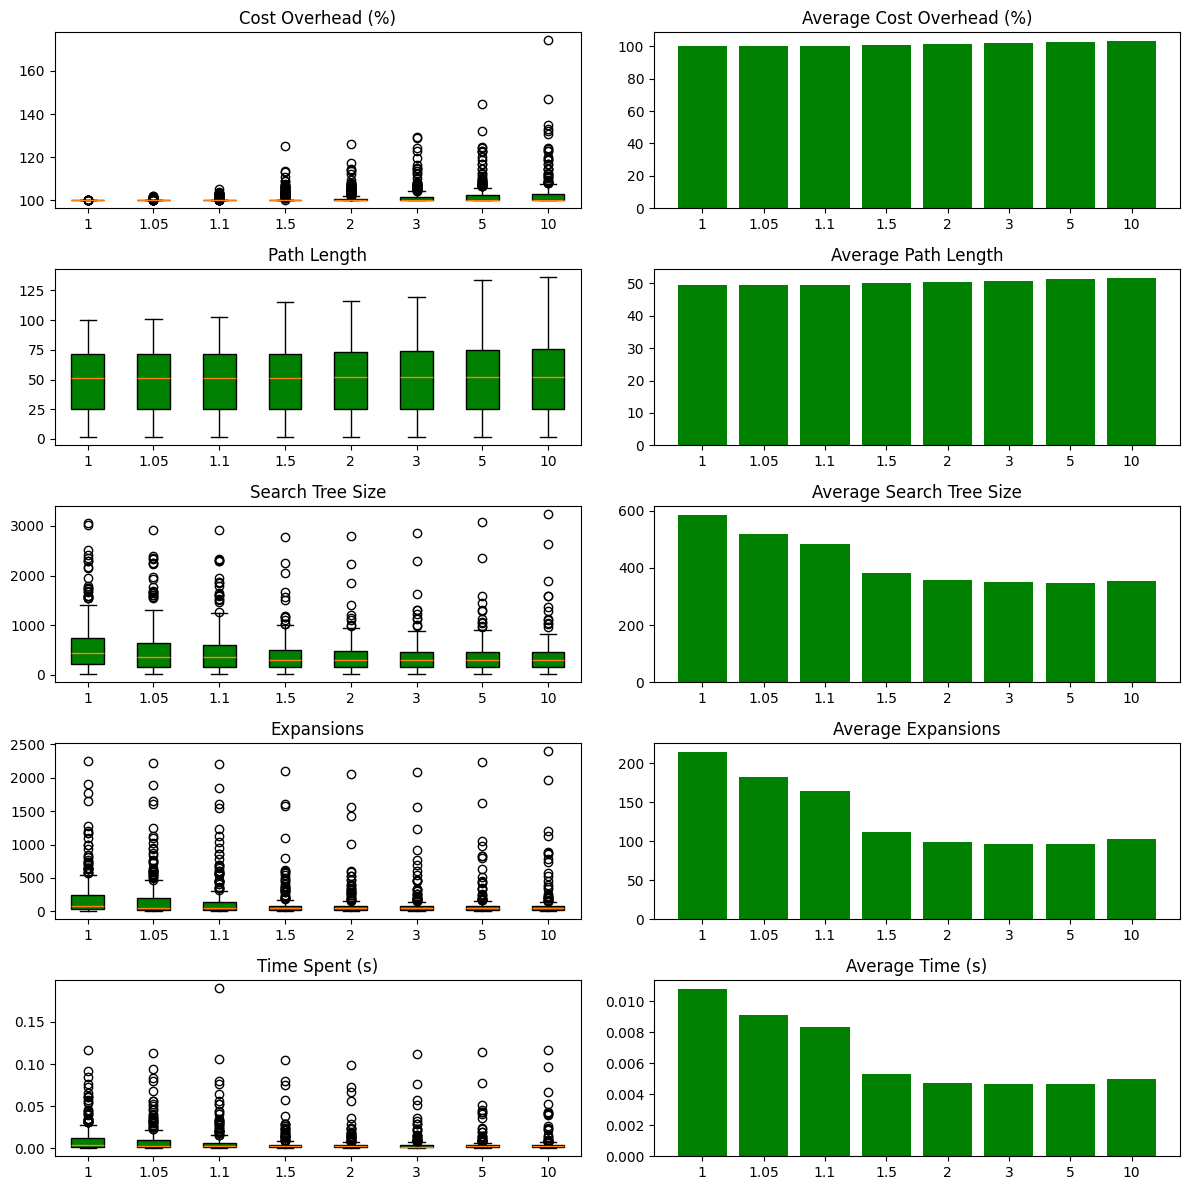

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 103%
Weight = 2: 105%
Weight = 3: 107%
Weight = 5: 109%
Weight = 10: 112%
=== Average path length: ===
Weight = 1: 247.376411
Weight = 1.05: 248.271701
Weight = 1.1: 249.731743
Weight = 1.5: 256.657697
Weight = 2: 259.969597
Weight = 3: 265.778369
Weight = 5: 271.873975
Weight = 10: 278.178411
=== Average search tree size: ===
Weight = 1: 13209
Weight = 1.05: 8128
Weight = 1.1: 7084
Weight = 1.5: 4350
Weight = 2: 3302
Weight = 3: 2786
Weight = 5: 2544
Weight = 10: 2393
=== Average expansions: ===
Weight = 1: 7966
Weight = 1.05: 5827
Weight = 1.1: 5095
Weight = 1.5: 2908
Weight = 2: 2024
Weight = 3: 1580
Weight = 5: 1361
Weight = 10: 1224
=== Average time usage: ===
Weight = 1: 0.5581 s
Wei

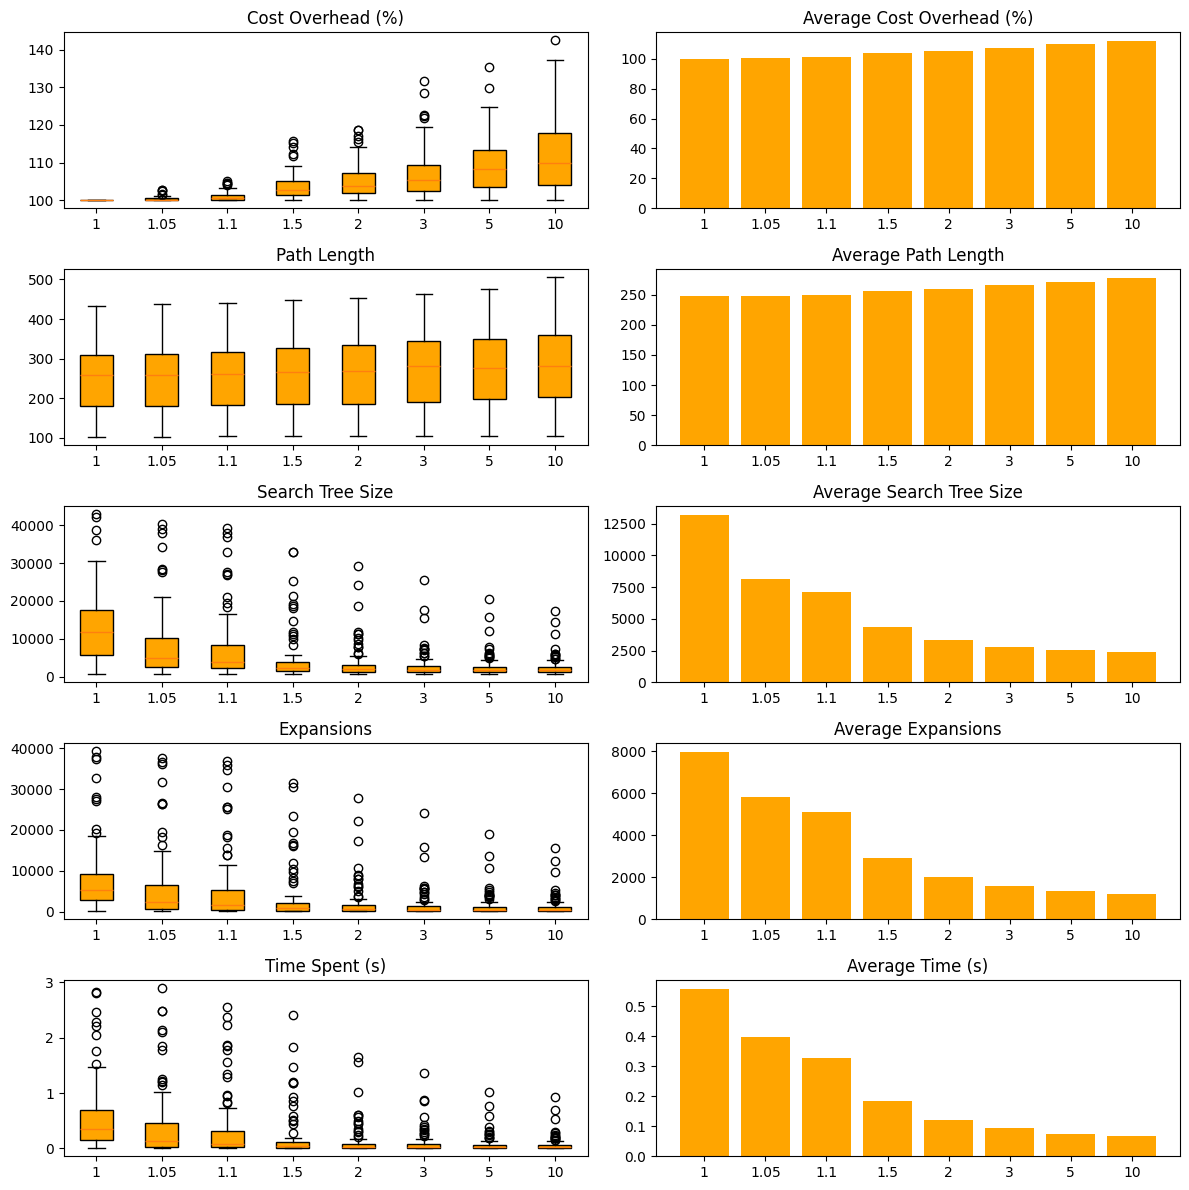

No Hard tasks found in the scenarios
No Brutal tasks found in the scenarios


In [21]:
city256_scenarios = [
    'Berlin_0_256.map.scen',
    'Berlin_1_256.map.scen',
    'London_2_256.map.scen',
    'Milan_1_256.map.scen',
    'Moscow_0_256.map.scen',
    'Paris_1_256.map.scen',
    'Shanghai_0_256.map.scen',
    'Sydney_2_256.map.scen'
]

test_on_scenarios(city256_scenarios)

#### Test Summary

So, from these graphs, we can see that the sub-optimal algorithms, despite theoretically being able to show up to 2x, 3x, 5x or even 10x cost overhead, in practice do not exceed about 1.8x cost overhead and 1.12x average, while giving us a significant upgrade in execution time (WA* with weight = 1.5 already spends more than 2x less time than A*).

### 8.2. City Maps 1024x1024

In this section, the algorithm will also be tested on city maps, but now they're more massive (1024x1024). Only 4 maps will be used (Berlin, Milan, Moscow and Shanghai).

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 100%
Weight = 2: 100%
Weight = 3: 100%
Weight = 5: 100%
Weight = 10: 100%
=== Average path length: ===
Weight = 1: 46.532103
Weight = 1.05: 46.551986
Weight = 1.1: 46.571868
Weight = 1.5: 46.611632
Weight = 2: 46.634828
Weight = 3: 46.639515
Weight = 5: 46.648485
Weight = 10: 46.648485
=== Average search tree size: ===
Weight = 1: 363
Weight = 1.05: 292
Weight = 1.1: 292
Weight = 1.5: 281
Weight = 2: 279
Weight = 3: 279
Weight = 5: 279
Weight = 10: 279
=== Average expansions: ===
Weight = 1: 64
Weight = 1.05: 47
Weight = 1.1: 46
Weight = 1.5: 40
Weight = 2: 40
Weight = 3: 40
Weight = 5: 40
Weight = 10: 40
=== Average time usage: ===
Weight = 1: 0.0038 s
Weight = 1.05: 0.0029 s
Weight = 1.1: 0.

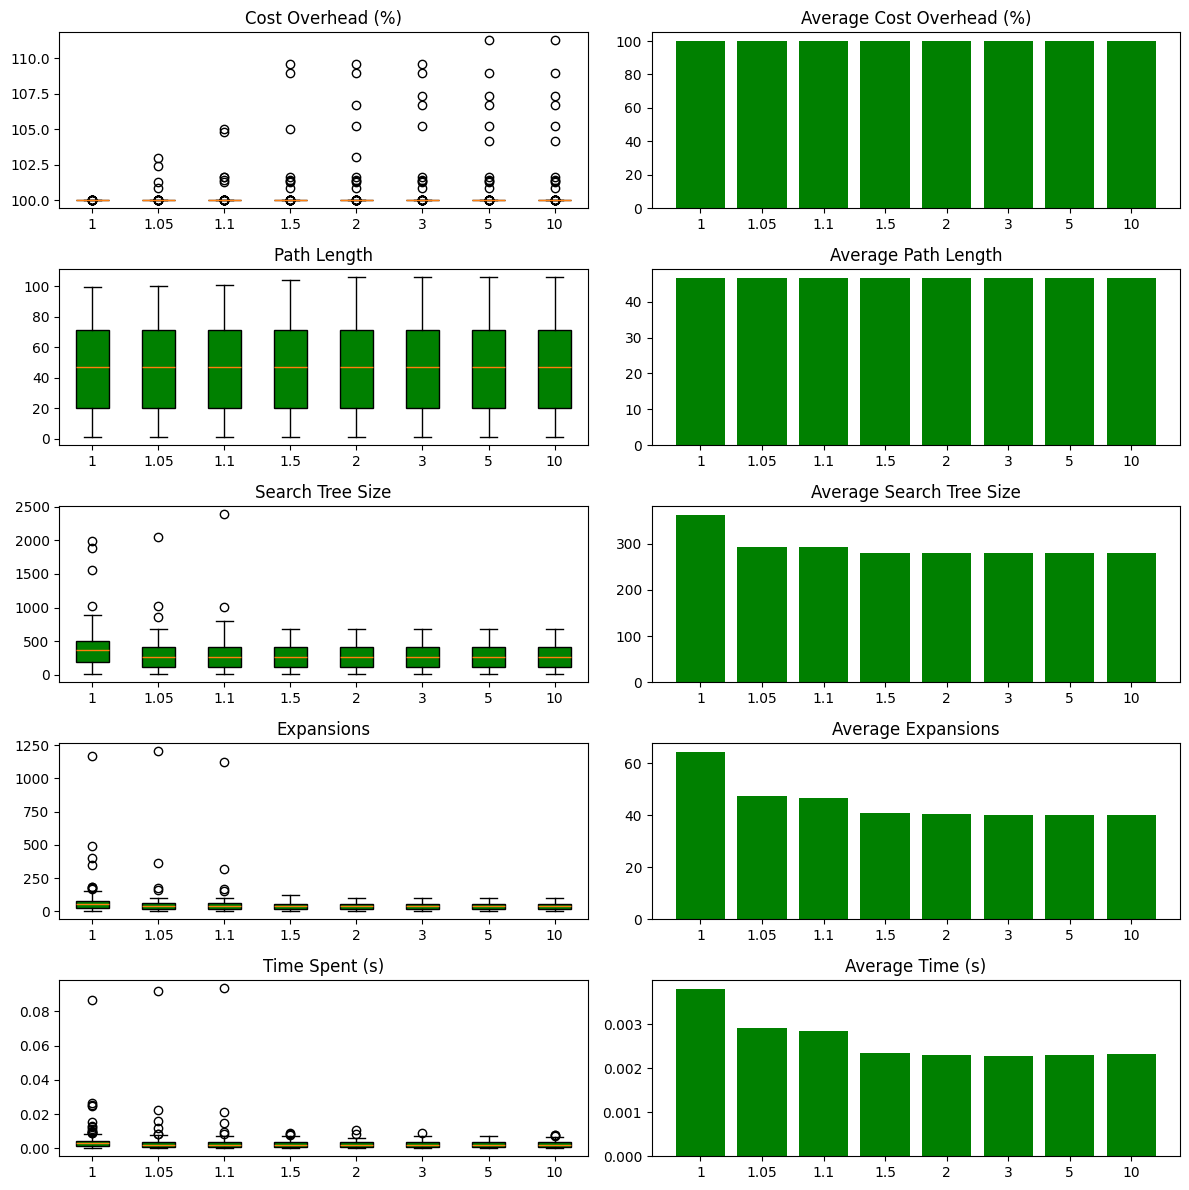

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 102%
Weight = 2: 103%
Weight = 3: 104%
Weight = 5: 104%
Weight = 10: 106%
=== Average path length: ===
Weight = 1: 307.585098
Weight = 1.05: 308.683647
Weight = 1.1: 309.785455
Weight = 1.5: 314.496880
Weight = 2: 318.034638
Weight = 3: 321.977166
Weight = 5: 324.592241
Weight = 10: 330.868120
=== Average search tree size: ===
Weight = 1: 32119
Weight = 1.05: 8011
Weight = 1.1: 7081
Weight = 1.5: 4017
Weight = 2: 3440
Weight = 3: 3072
Weight = 5: 2994
Weight = 10: 2938
=== Average expansions: ===
Weight = 1: 12196
Weight = 1.05: 5367
Weight = 1.1: 4671
Weight = 1.5: 2207
Weight = 2: 1796
Weight = 3: 1492
Weight = 5: 1430
Weight = 10: 1395
=== Average time usage: ===
Weight = 1: 0.9312 s
We

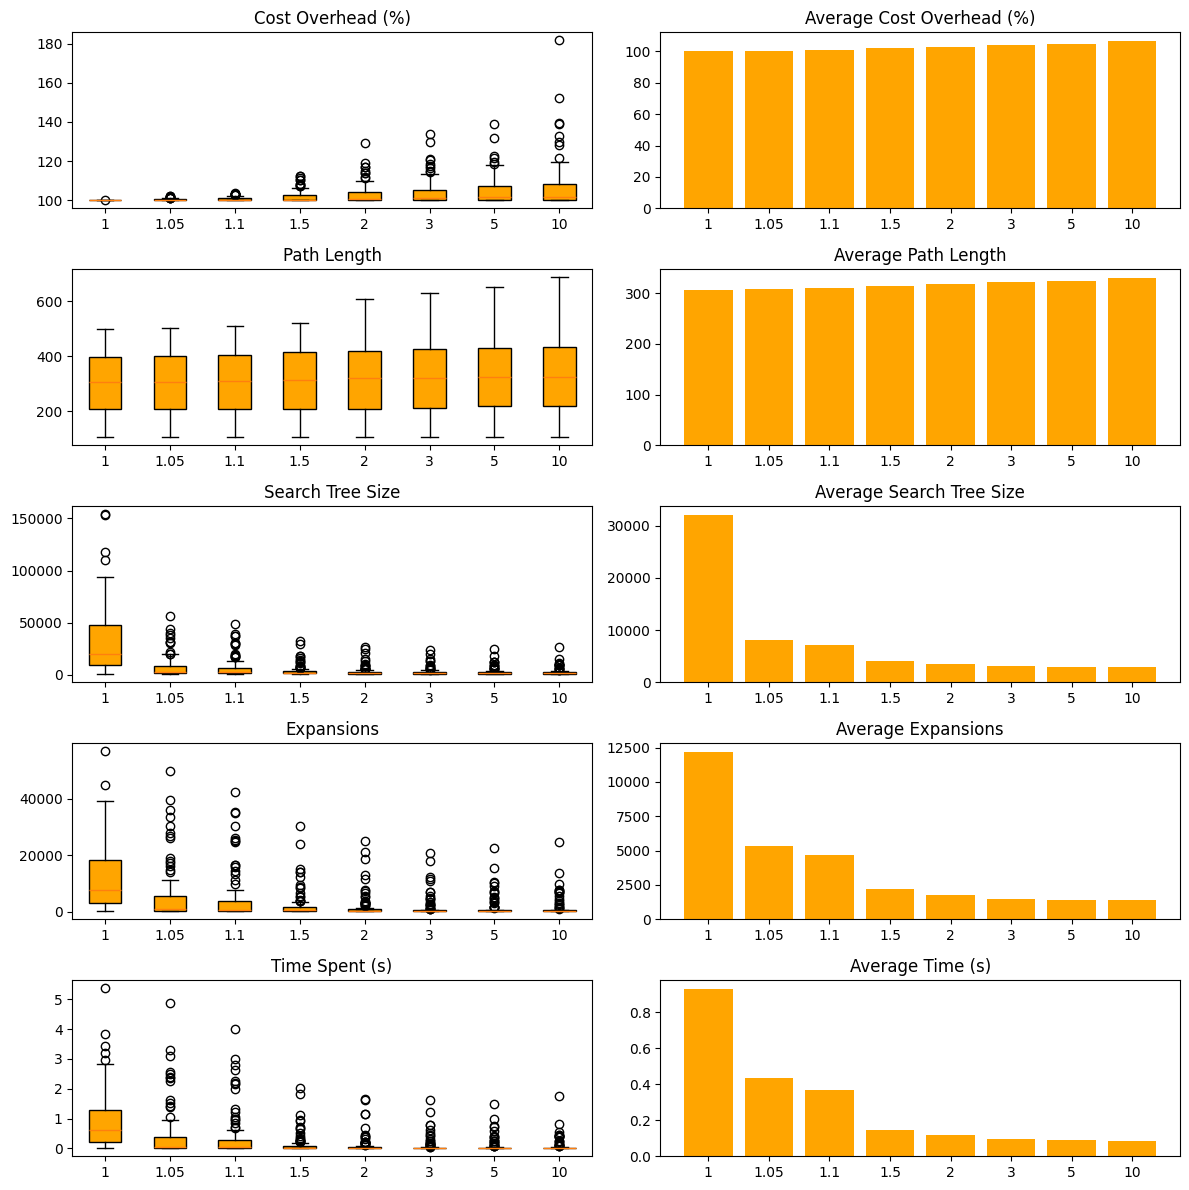

Running tests on Hard tasks (path length 500-1500), 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 101%
Weight = 1.5: 104%
Weight = 2: 106%
Weight = 3: 108%
Weight = 5: 109%
Weight = 10: 109%
=== Average path length: ===
Weight = 1: 1001.316303
Weight = 1.05: 1007.617087
Weight = 1.1: 1013.692219
Weight = 1.5: 1039.248888
Weight = 2: 1055.752685
Weight = 3: 1083.500134
Weight = 5: 1094.657493
Weight = 10: 1097.146798
=== Average search tree size: ===
Weight = 1: 172391
Weight = 1.05: 77066
Weight = 1.1: 58486
Weight = 1.5: 19695
Weight = 2: 12045
Weight = 3: 10566
Weight = 5: 9058
Weight = 10: 8411
=== Average expansions: ===
Weight = 1: 109495
Weight = 1.05: 66412
Weight = 1.1: 49517
Weight = 1.5: 13665
Weight = 2: 6940
Weight = 3: 5717
Weight = 5: 4361
Weight = 10: 3816
=== Average time usage: ===
Weight 

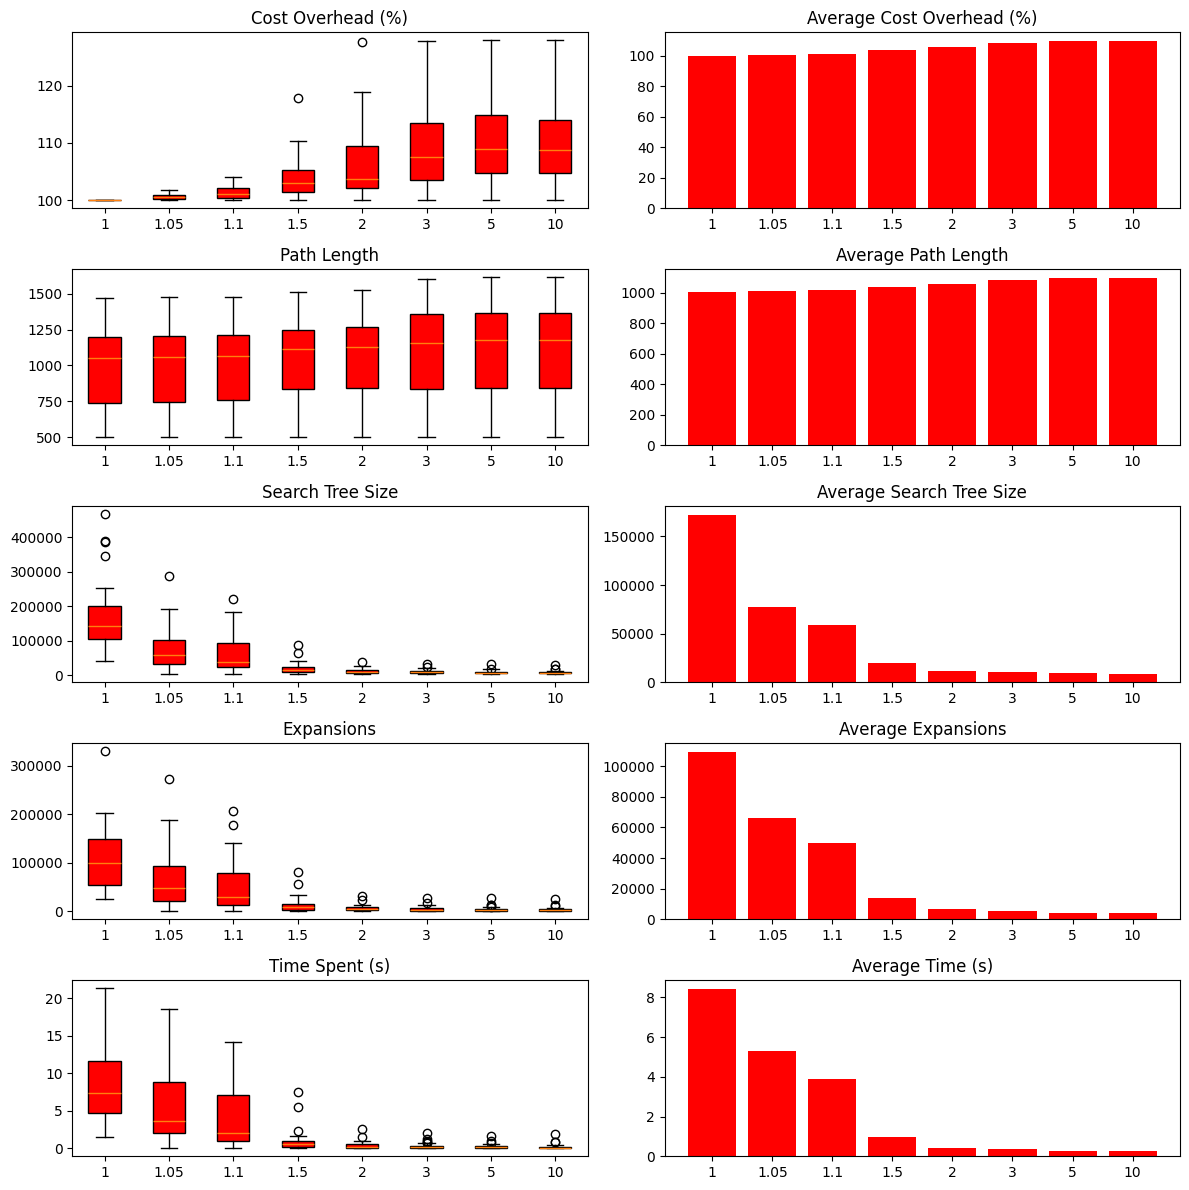

Running tests on Brutal tasks (path length >1500), 10 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 101%
Weight = 1.5: 103%
Weight = 2: 104%
Weight = 3: 106%
Weight = 5: 106%
Weight = 10: 107%
=== Average path length: ===
Weight = 1: 1527.657488
Weight = 1.05: 1533.976074
Weight = 1.1: 1544.218000
Weight = 1.5: 1583.327250
Weight = 2: 1598.313751
Weight = 3: 1624.306139
Weight = 5: 1629.576196
Weight = 10: 1635.899241
=== Average search tree size: ===
Weight = 1: 365127
Weight = 1.05: 236524
Weight = 1.1: 189648
Weight = 1.5: 37786
Weight = 2: 23625
Weight = 3: 14983
Weight = 5: 11849
Weight = 10: 11063
=== Average expansions: ===
Weight = 1: 276757
Weight = 1.05: 218880
Weight = 1.1: 173660
Weight = 1.5: 28052
Weight = 2: 16106
Weight = 3: 7968
Weight = 5: 5065
Weight = 10: 4407
=== Average time usage: ===
W

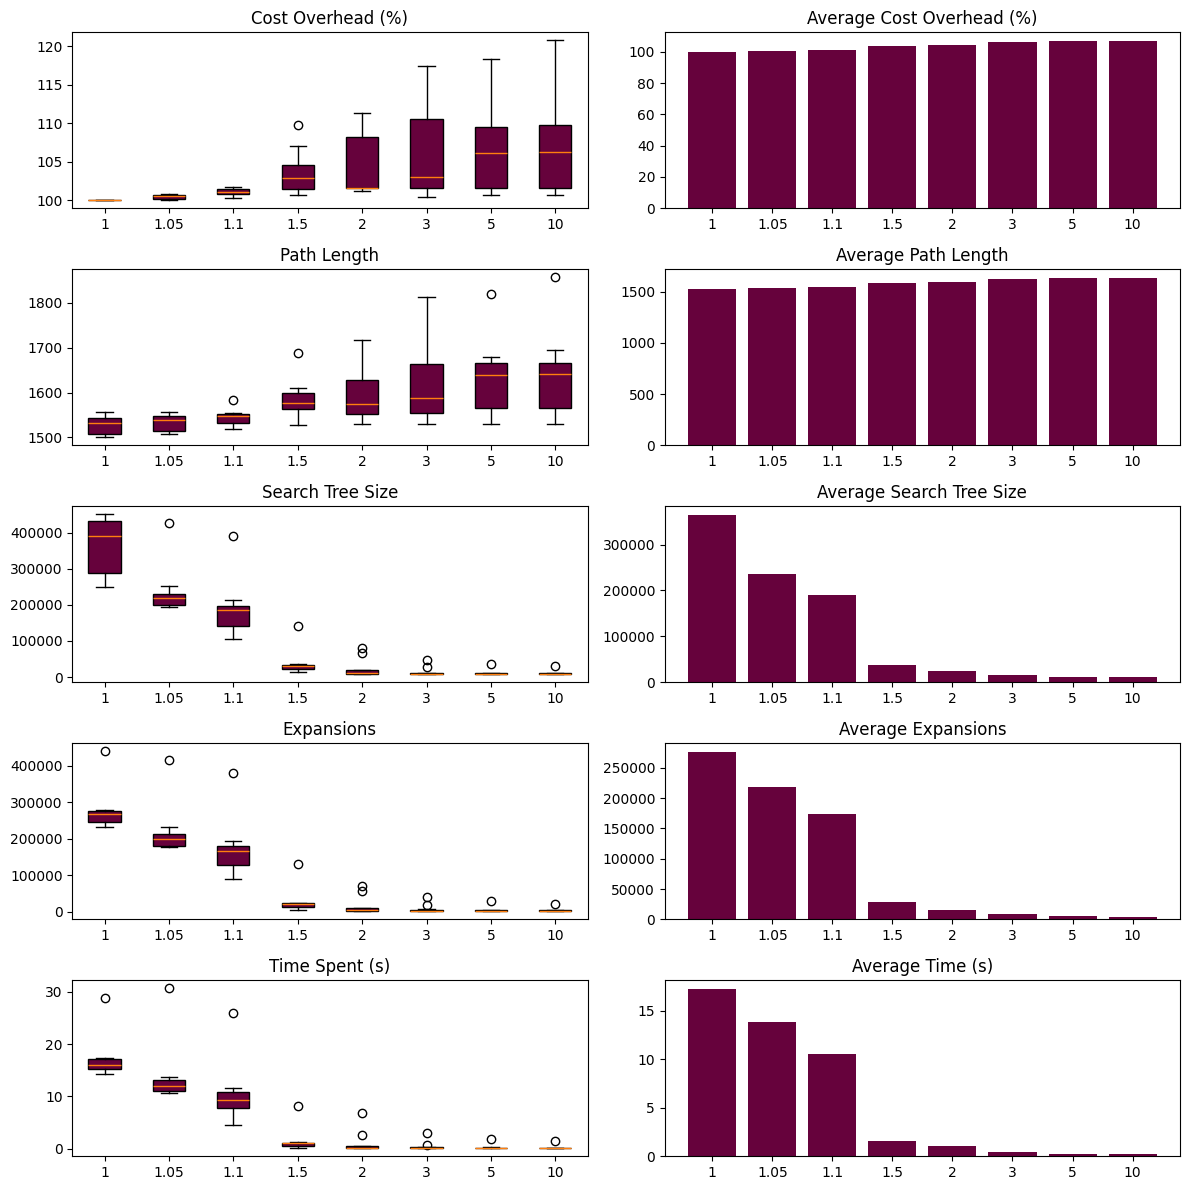

In [22]:
city1024_scenarios = [
    'Berlin_1_1024.map.scen',
    'Milan_1_1024.map.scen',
    'Moscow_0_1024.map.scen',
    'Shanghai_0_1024.map.scen'
]

test_on_scenarios(city1024_scenarios)

#### Test Summary

The trend from the previous test continues. Now we can see that the weighted algorithms get no more than 10% average cost overhead (and in vast majority of cases no more than 25%), but save a LOT of execution time. On Hard and Brutal tasks, WA* with weight 2 already gives 16x (!) time advantage.

### 8.3. Random Maps

This test consists of completely random maps, meaning it is totally random for a cell to be a wall or a passage. Shaped 512x512. Maps of different densities are used.

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 102%
Weight = 2: 104%
Weight = 3: 105%
Weight = 5: 107%
Weight = 10: 107%
=== Average path length: ===
Weight = 1: 48.175545
Weight = 1.05: 48.256114
Weight = 1.1: 48.428967
Weight = 1.5: 49.691651
Weight = 2: 50.866835
Weight = 3: 51.492139
Weight = 5: 52.432687
Weight = 10: 52.962559
=== Average search tree size: ===
Weight = 1: 620
Weight = 1.05: 478
Weight = 1.1: 394
Weight = 1.5: 256
Weight = 2: 236
Weight = 3: 225
Weight = 5: 223
Weight = 10: 224
=== Average expansions: ===
Weight = 1: 312
Weight = 1.05: 234
Weight = 1.1: 184
Weight = 1.5: 98
Weight = 2: 82
Weight = 3: 73
Weight = 5: 72
Weight = 10: 72
=== Average time usage: ===
Weight = 1: 0.0077 s
Weight = 1.05: 0.0060 s
Weight = 1.1:

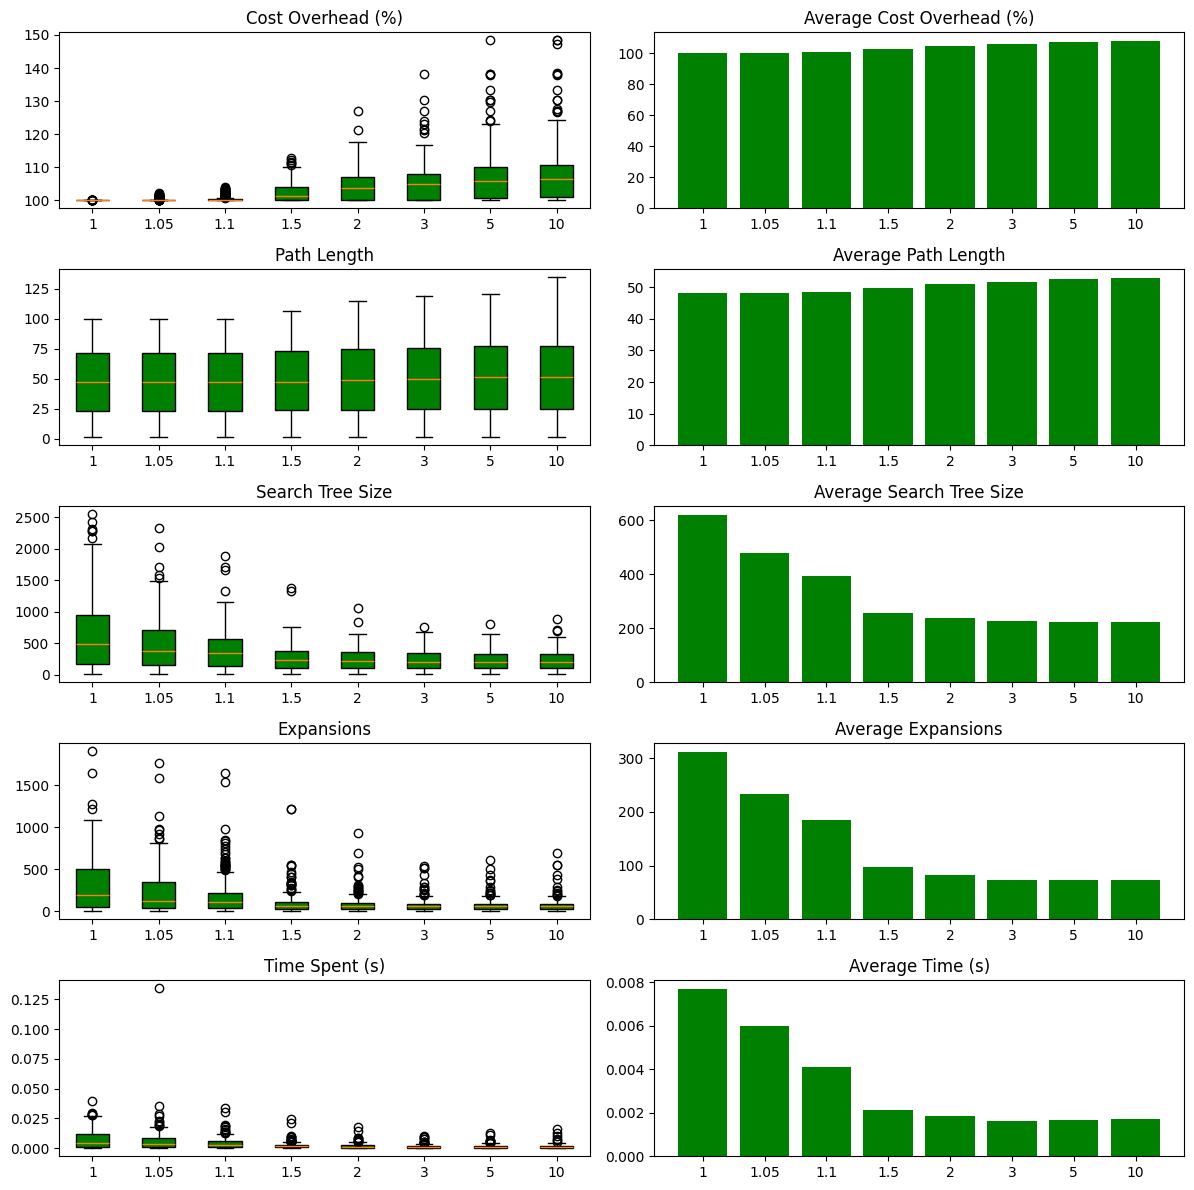

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 104%
Weight = 2: 108%
Weight = 3: 109%
Weight = 5: 112%
Weight = 10: 114%
=== Average path length: ===
Weight = 1: 293.275752
Weight = 1.05: 294.383103
Weight = 1.1: 296.062931
Weight = 1.5: 308.168242
Weight = 2: 317.905310
Weight = 3: 322.436681
Weight = 5: 330.121088
Weight = 10: 335.276723
=== Average search tree size: ===
Weight = 1: 15028
Weight = 1.05: 7985
Weight = 1.1: 5402
Weight = 1.5: 1872
Weight = 2: 1632
Weight = 3: 1488
Weight = 5: 1467
Weight = 10: 1451
=== Average expansions: ===
Weight = 1: 10534
Weight = 1.05: 6013
Weight = 1.1: 3869
Weight = 1.5: 902
Weight = 2: 700
Weight = 3: 571
Weight = 5: 550
Weight = 10: 534
=== Average time usage: ===
Weight = 1: 0.3297 s
Weight 

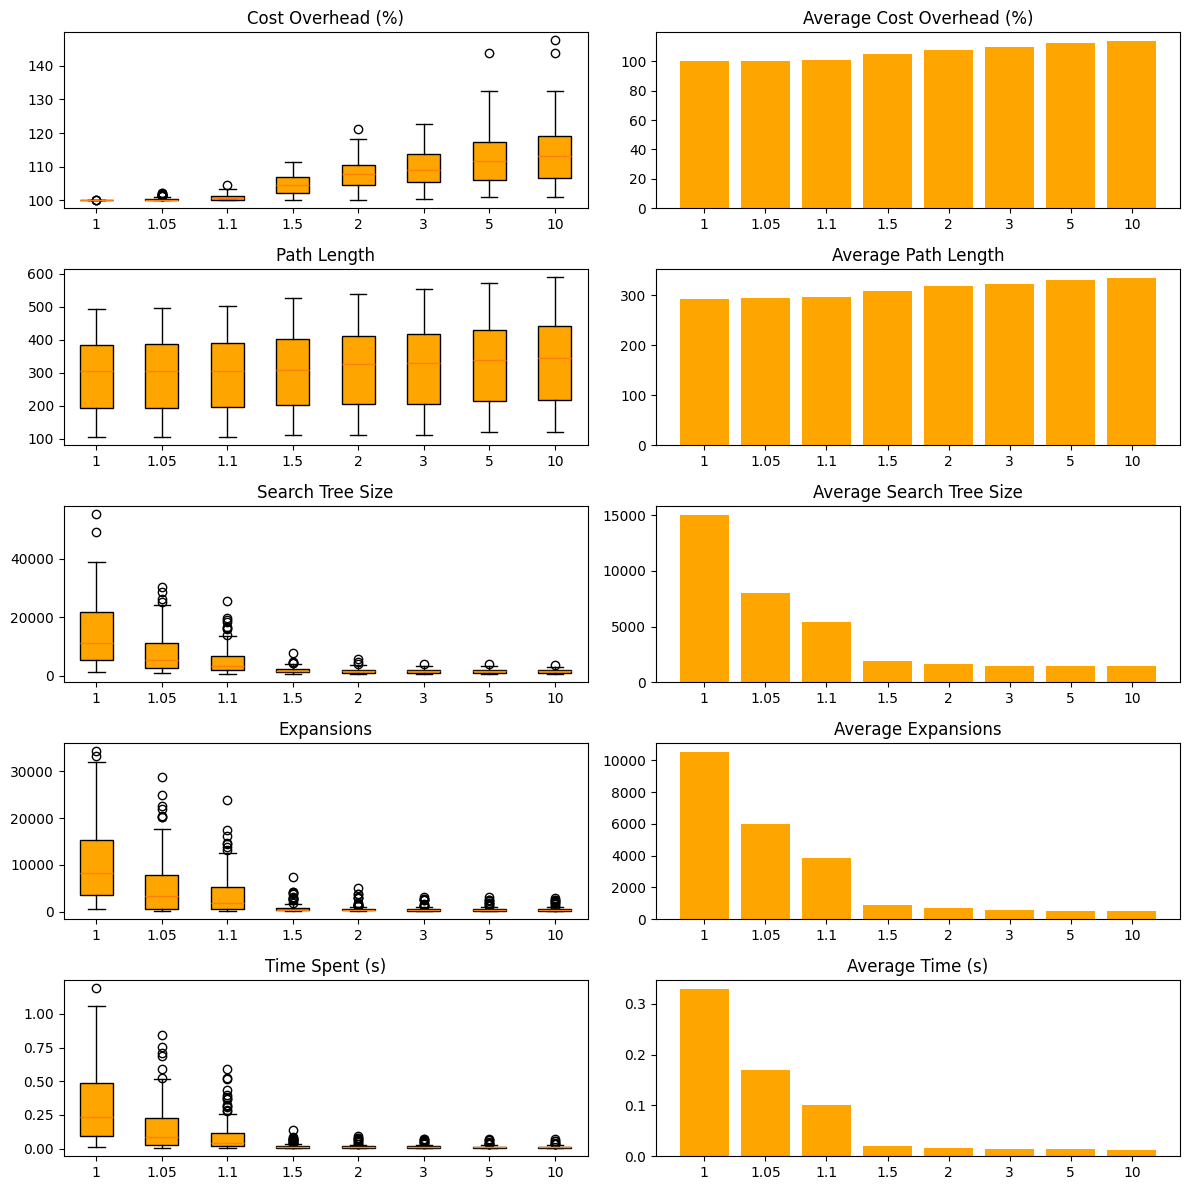

Running tests on Hard tasks (path length 500-1500), 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 104%
Weight = 2: 107%
Weight = 3: 110%
Weight = 5: 114%
Weight = 10: 117%
=== Average path length: ===
Weight = 1: 723.329271
Weight = 1.05: 723.964973
Weight = 1.1: 726.994312
Weight = 1.5: 756.709942
Weight = 2: 776.794451
Weight = 3: 801.746399
Weight = 5: 825.699973
Weight = 10: 851.438857
=== Average search tree size: ===
Weight = 1: 55429
Weight = 1.05: 43723
Weight = 1.1: 34645
Weight = 1.5: 11046
Weight = 2: 7411
Weight = 3: 5083
Weight = 5: 4564
Weight = 10: 4414
=== Average expansions: ===
Weight = 1: 51972
Weight = 1.05: 40805
Weight = 1.1: 31398
Weight = 1.5: 9453
Weight = 2: 5862
Weight = 3: 3479
Weight = 5: 2940
Weight = 10: 2749
=== Average time usage: ===
Weight = 1: 1.5588 s

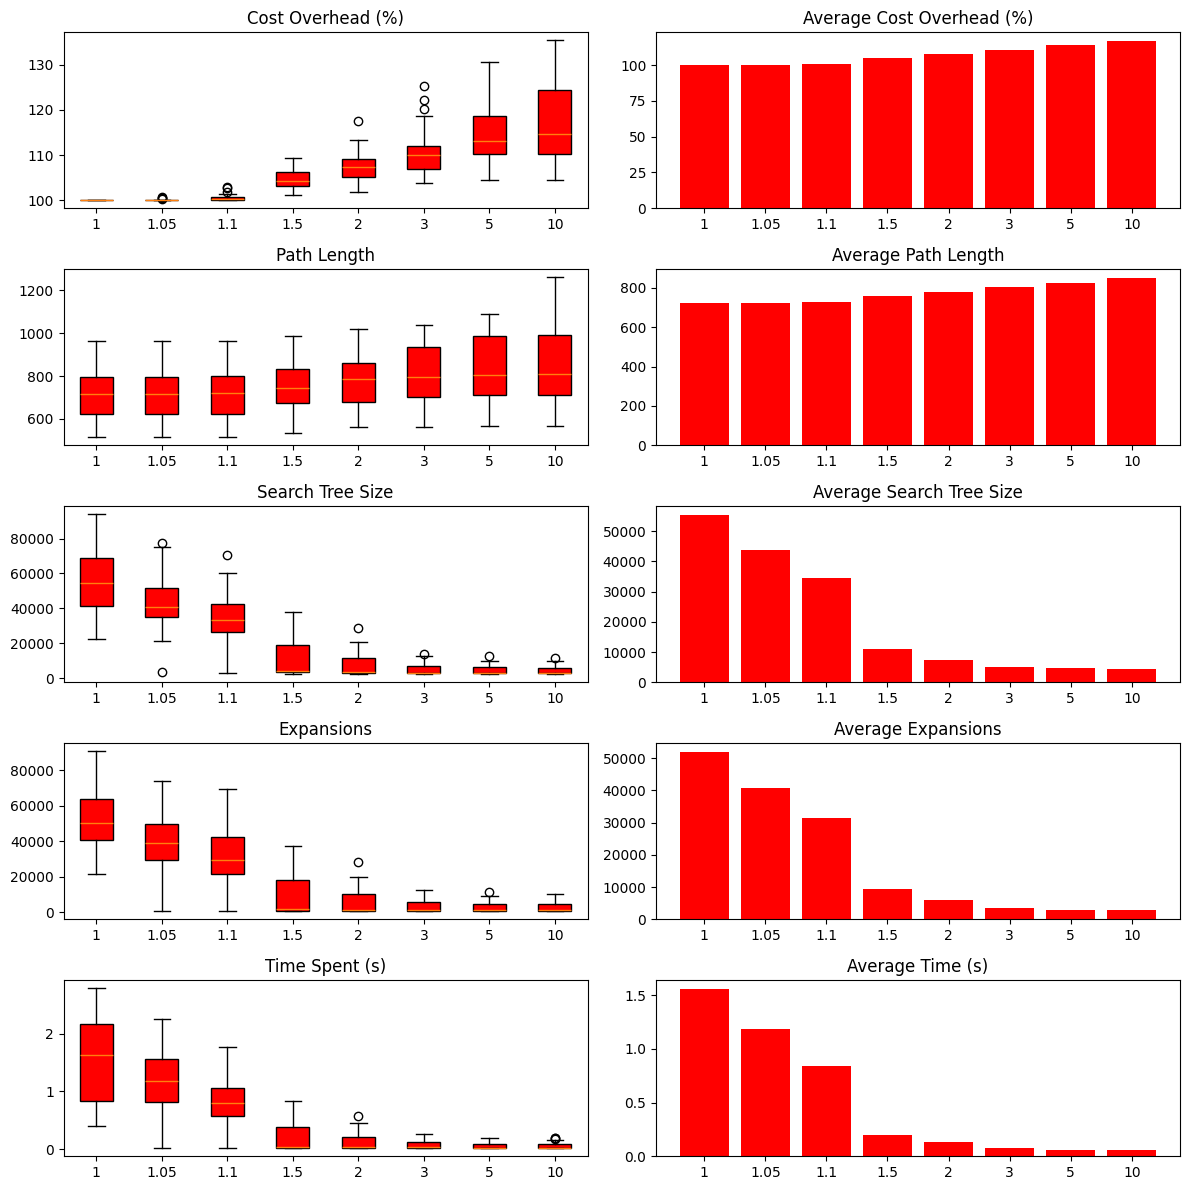

No Brutal tasks found in the scenarios


In [23]:
random_scenarios = [
    'random512-10-0.map.scen',
    'random512-15-4.map.scen',
    'random512-20-6.map.scen',
    'random512-25-5.map.scen',
    'random512-30-9.map.scen',
    'random512-35-7.map.scen',
    'random512-40-2.map.scen'
]

test_on_scenarios(random_scenarios)

### Test Summary

The results of these tests are mostly the same as of tests before. Actually, I think that on most random maps, if the path exists, it does not differ very much from a straight line, that's just because of how random maps work. The weighted algorithms with large weighs (5, 10) tend to give slightly more cost overhead than on previous tests, however still no more than 40% (not counting outliers). Why could this be happening? Maybe it is that because random maps don't have large portions of empty space, which any algorithm with Octile heuristic just speeds through, finding the optimal path in them on the first try.

### 8.4. Maze Maps

This test consists of maps shaped like mazes. Mazes with variable corridor width are used.

Example:

<img src="./img/maze512-32-0.png">

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 100%
Weight = 2: 100%
Weight = 3: 101%
Weight = 5: 102%
Weight = 10: 103%
=== Average path length: ===
Weight = 1: 49.055895
Weight = 1.05: 49.062522
Weight = 1.1: 49.082405
Weight = 1.5: 49.334246
Weight = 2: 49.596029
Weight = 3: 49.843461
Weight = 5: 50.715627
Weight = 10: 51.430844
=== Average search tree size: ===
Weight = 1: 573
Weight = 1.05: 519
Weight = 1.1: 507
Weight = 1.5: 442
Weight = 2: 412
Weight = 3: 392
Weight = 5: 395
Weight = 10: 396
=== Average expansions: ===
Weight = 1: 310
Weight = 1.05: 287
Weight = 1.1: 275
Weight = 1.5: 220
Weight = 2: 197
Weight = 3: 184
Weight = 5: 186
Weight = 10: 188
=== Average time usage: ===
Weight = 1: 0.0115 s
Weight = 1.05: 0.0101 s
Weight =

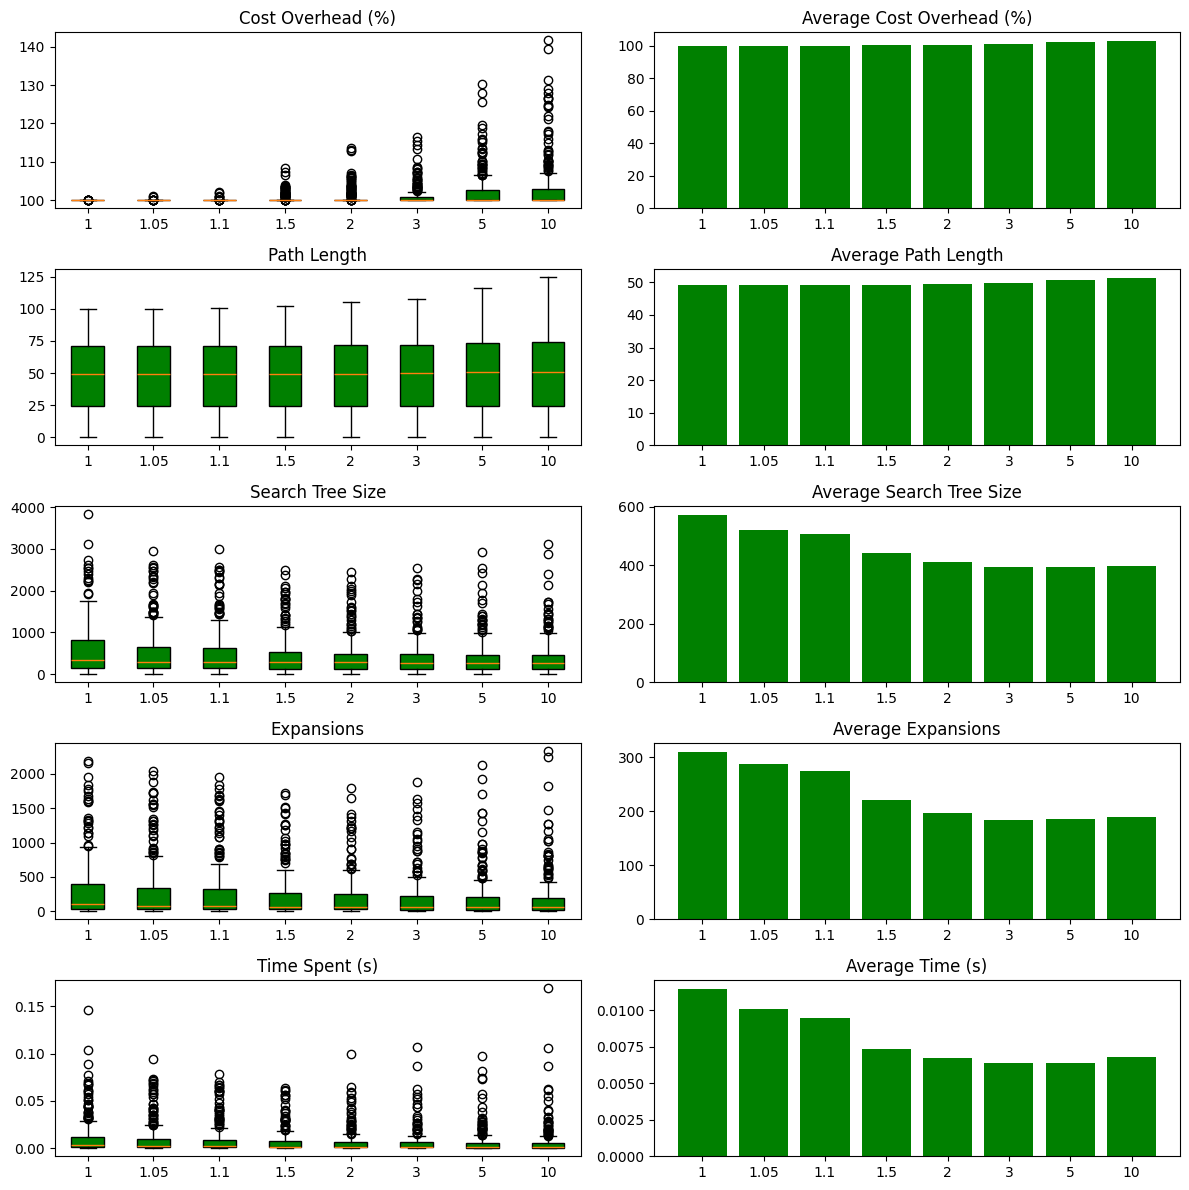

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 101%
Weight = 2: 101%
Weight = 3: 103%
Weight = 5: 106%
Weight = 10: 108%
=== Average path length: ===
Weight = 1: 315.249041
Weight = 1.05: 315.547275
Weight = 1.1: 316.176879
Weight = 1.5: 319.242060
Weight = 2: 321.362833
Weight = 3: 326.216832
Weight = 5: 337.106984
Weight = 10: 342.568679
=== Average search tree size: ===
Weight = 1: 12040
Weight = 1.05: 11067
Weight = 1.1: 10741
Weight = 1.5: 8902
Weight = 2: 7830
Weight = 3: 6873
Weight = 5: 6580
Weight = 10: 6492
=== Average expansions: ===
Weight = 1: 10713
Weight = 1.05: 10182
Weight = 1.1: 9862
Weight = 1.5: 7984
Weight = 2: 6929
Weight = 3: 5968
Weight = 5: 5655
Weight = 10: 5572
=== Average time usage: ===
Weight = 1: 0.3982 s

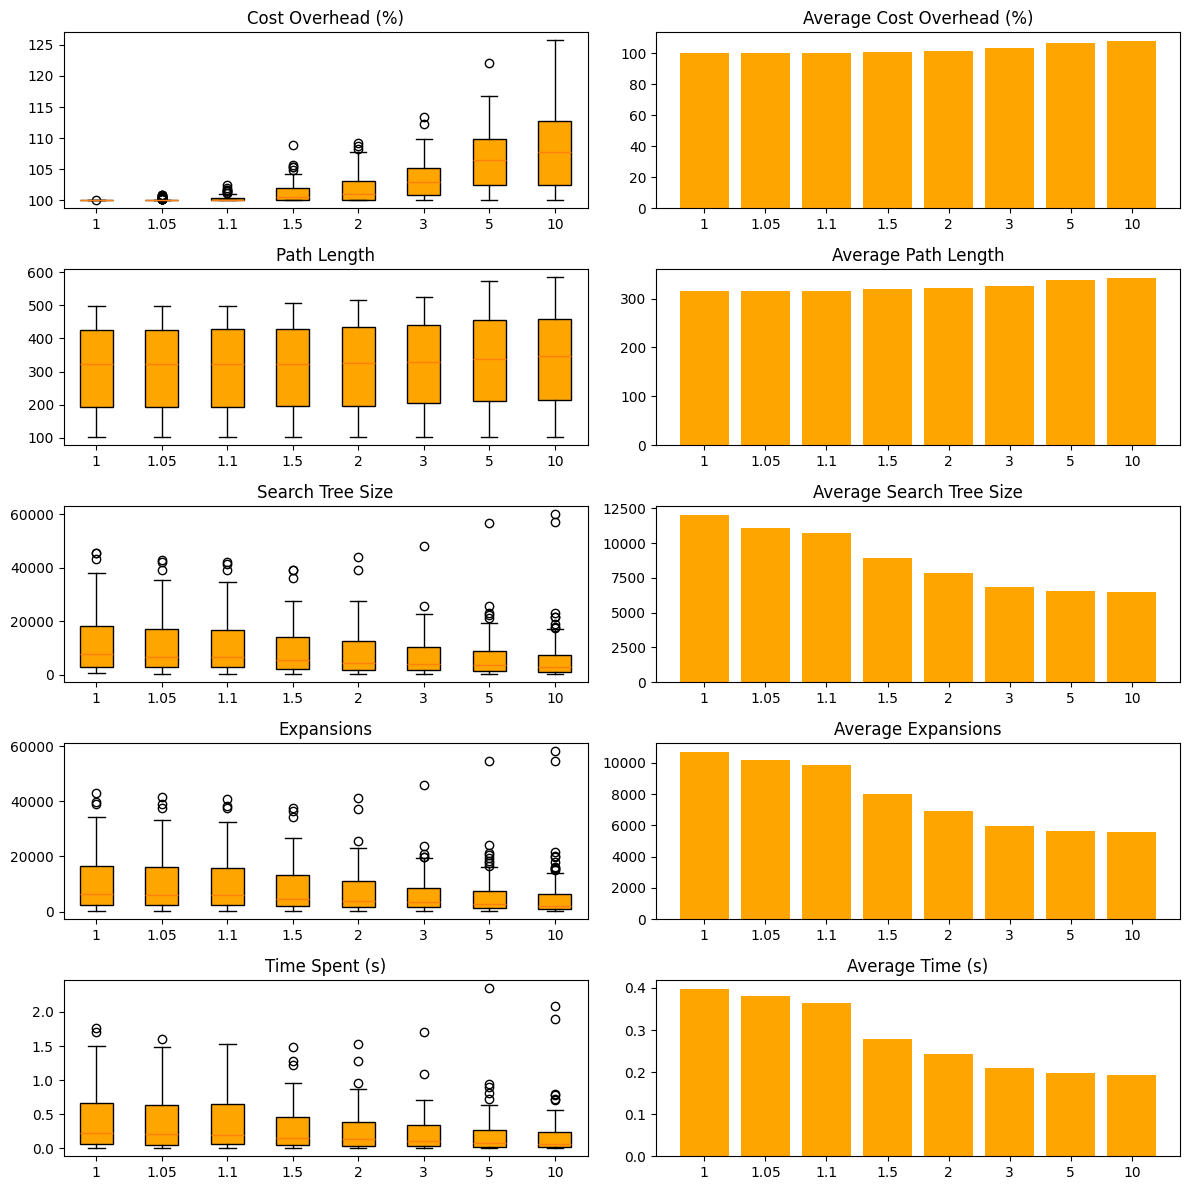

Running tests on Hard tasks (path length 500-1500), 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 100%
Weight = 2: 101%
Weight = 3: 102%
Weight = 5: 106%
Weight = 10: 108%
=== Average path length: ===
Weight = 1: 949.843763
Weight = 1.05: 950.423662
Weight = 1.1: 951.583460
Weight = 1.5: 958.266106
Weight = 2: 963.512811
Weight = 3: 976.872946
Weight = 5: 1006.203504
Weight = 10: 1022.638155
=== Average search tree size: ===
Weight = 1: 62892
Weight = 1.05: 61209
Weight = 1.1: 60327
Weight = 1.5: 54622
Weight = 2: 49376
Weight = 3: 42861
Weight = 5: 36269
Weight = 10: 34732
=== Average expansions: ===
Weight = 1: 61238
Weight = 1.05: 60141
Weight = 1.1: 59228
Weight = 1.5: 53404
Weight = 2: 48156
Weight = 3: 41381
Weight = 5: 34693
Weight = 10: 32914
=== Average time usage: ===
Weight = 

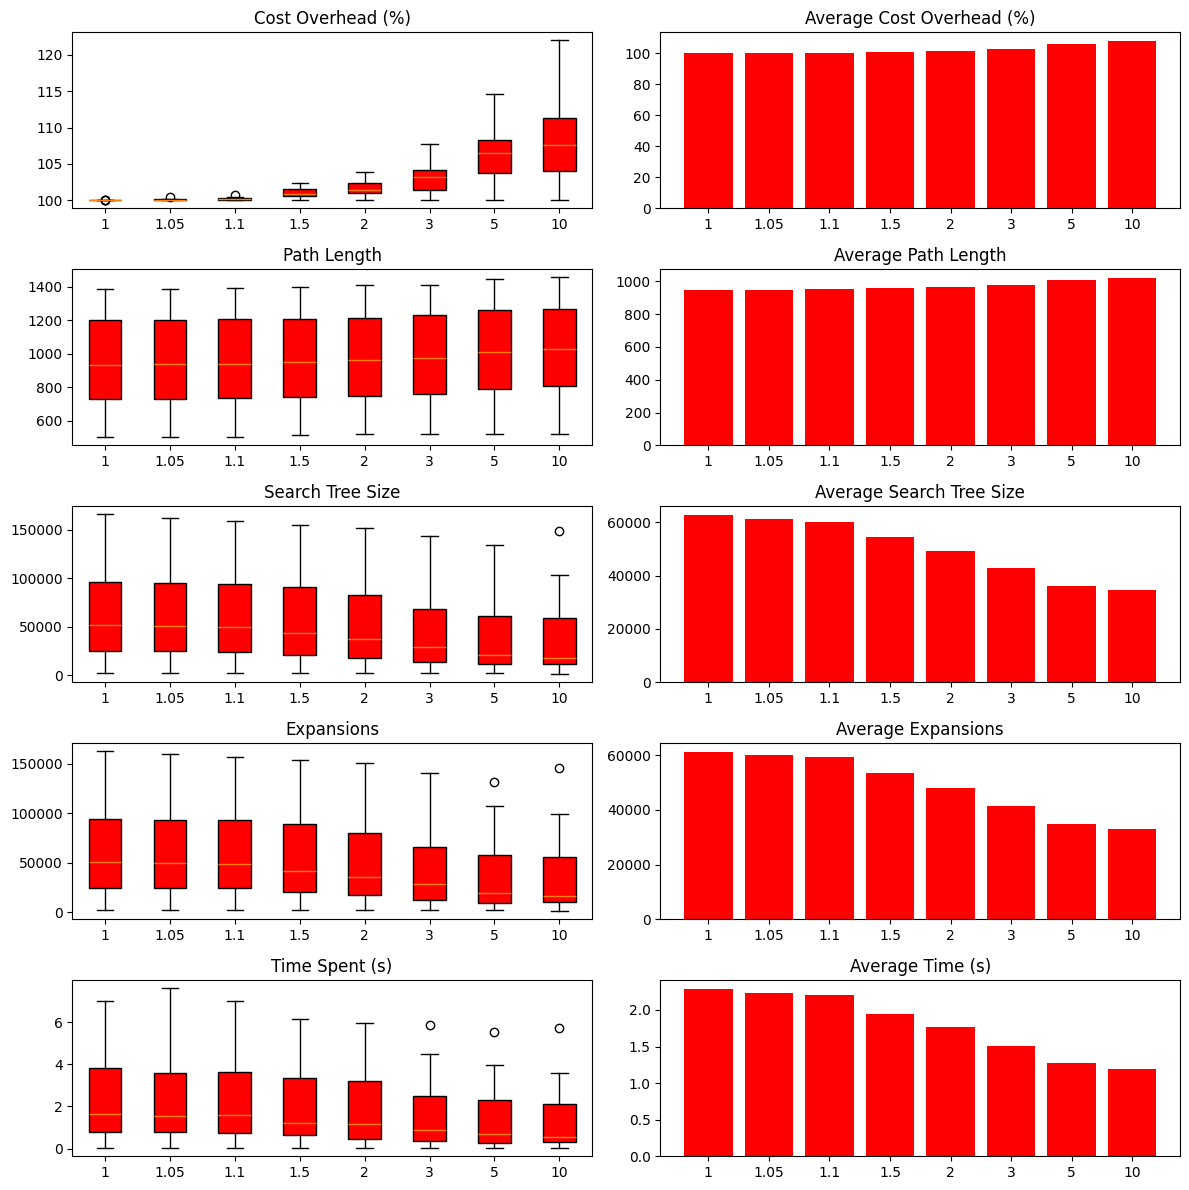

Running tests on Brutal tasks (path length >1500), 10 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 100%
Weight = 2: 101%
Weight = 3: 102%
Weight = 5: 105%
Weight = 10: 106%
=== Average path length: ===
Weight = 1: 2978.614429
Weight = 1.05: 2979.277171
Weight = 1.1: 2982.342351
Weight = 1.5: 3000.733433
Weight = 2: 3022.024010
Weight = 3: 3056.116903
Weight = 5: 3146.534566
Weight = 10: 3182.170605
=== Average search tree size: ===
Weight = 1: 141608
Weight = 1.05: 140933
Weight = 1.1: 140209
Weight = 1.5: 135042
Weight = 2: 127945
Weight = 3: 112026
Weight = 5: 88270
Weight = 10: 69846
=== Average expansions: ===
Weight = 1: 141100
Weight = 1.05: 140437
Weight = 1.1: 139731
Weight = 1.5: 134519
Weight = 2: 127141
Weight = 3: 110923
Weight = 5: 86833
Weight = 10: 67764
=== Average time usa

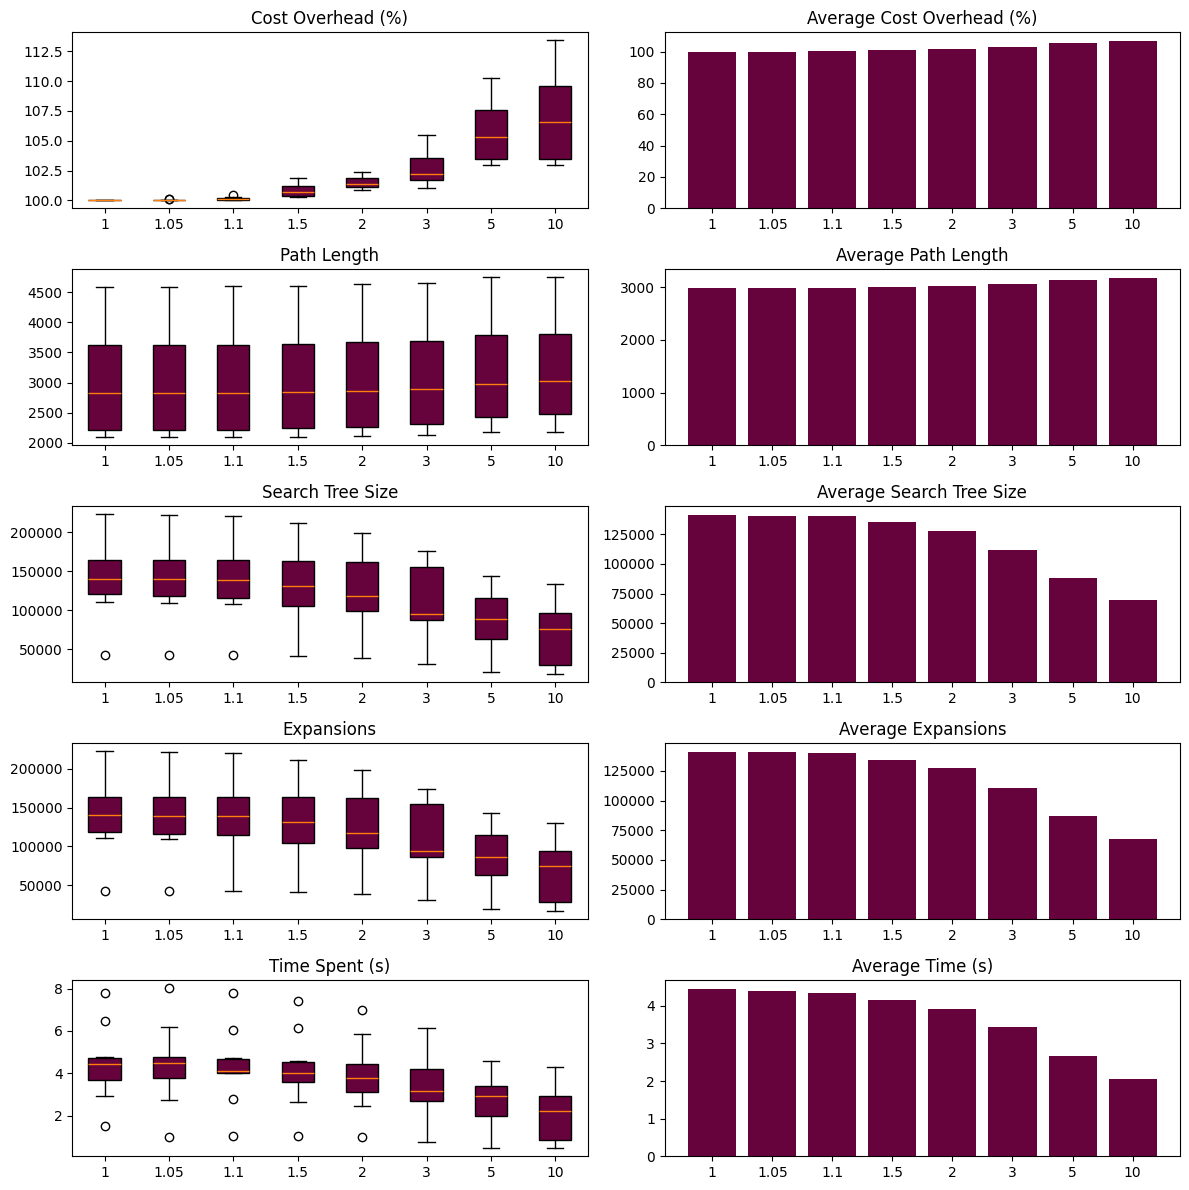

In [24]:
maze_scenarios = [
    'maze512-1-0.map.scen',
    'maze512-2-8.map.scen',
    'maze512-4-8.map.scen',
    'maze512-8-8.map.scen',
    'maze512-16-2.map.scen',
    'maze512-32-0.map.scen',
    'maze512-32-9.map.scen',
]

test_on_scenarios(maze_scenarios)

#### Test Summary

Now that is more interesting. The cost overhead is still low, but the execution time gain has decreased significantly. This is because in artificial maze-shaped maps, heuristic is deceiving and the optimal path between two nearby cells can often go through the whole map. While weighted algorithms can still get advantage, they can't save more than a half time the standard A* algorithm spends. Also, notice how the cost overhead now grows proportionally to the weight, while before it seemed to grow slower than the weight. However, I think that maze-shaped maps would occur rarely in practice (except for maybe computer games).

### 8.5. Rooms Maps

This test consists of maps shaped like a large room grid with small openings in the walls. Maps with variable room size are used.

Example:

<img src="./img/64room_003.png">

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 102%
Weight = 2: 103%
Weight = 3: 105%
Weight = 5: 109%
Weight = 10: 113%
=== Average path length: ===
Weight = 1: 48.660517
Weight = 1.05: 48.708282
Weight = 1.1: 48.848830
Weight = 1.5: 50.011747
Weight = 2: 51.098919
Weight = 3: 52.346086
Weight = 5: 54.924194
Weight = 10: 57.474419
=== Average search tree size: ===
Weight = 1: 876
Weight = 1.05: 828
Weight = 1.1: 775
Weight = 1.5: 581
Weight = 2: 515
Weight = 3: 472
Weight = 5: 457
Weight = 10: 449
=== Average expansions: ===
Weight = 1: 474
Weight = 1.05: 428
Weight = 1.1: 389
Weight = 1.5: 260
Weight = 2: 226
Weight = 3: 205
Weight = 5: 197
Weight = 10: 194
=== Average time usage: ===
Weight = 1: 0.0150 s
Weight = 1.05: 0.0137 s
Weight =

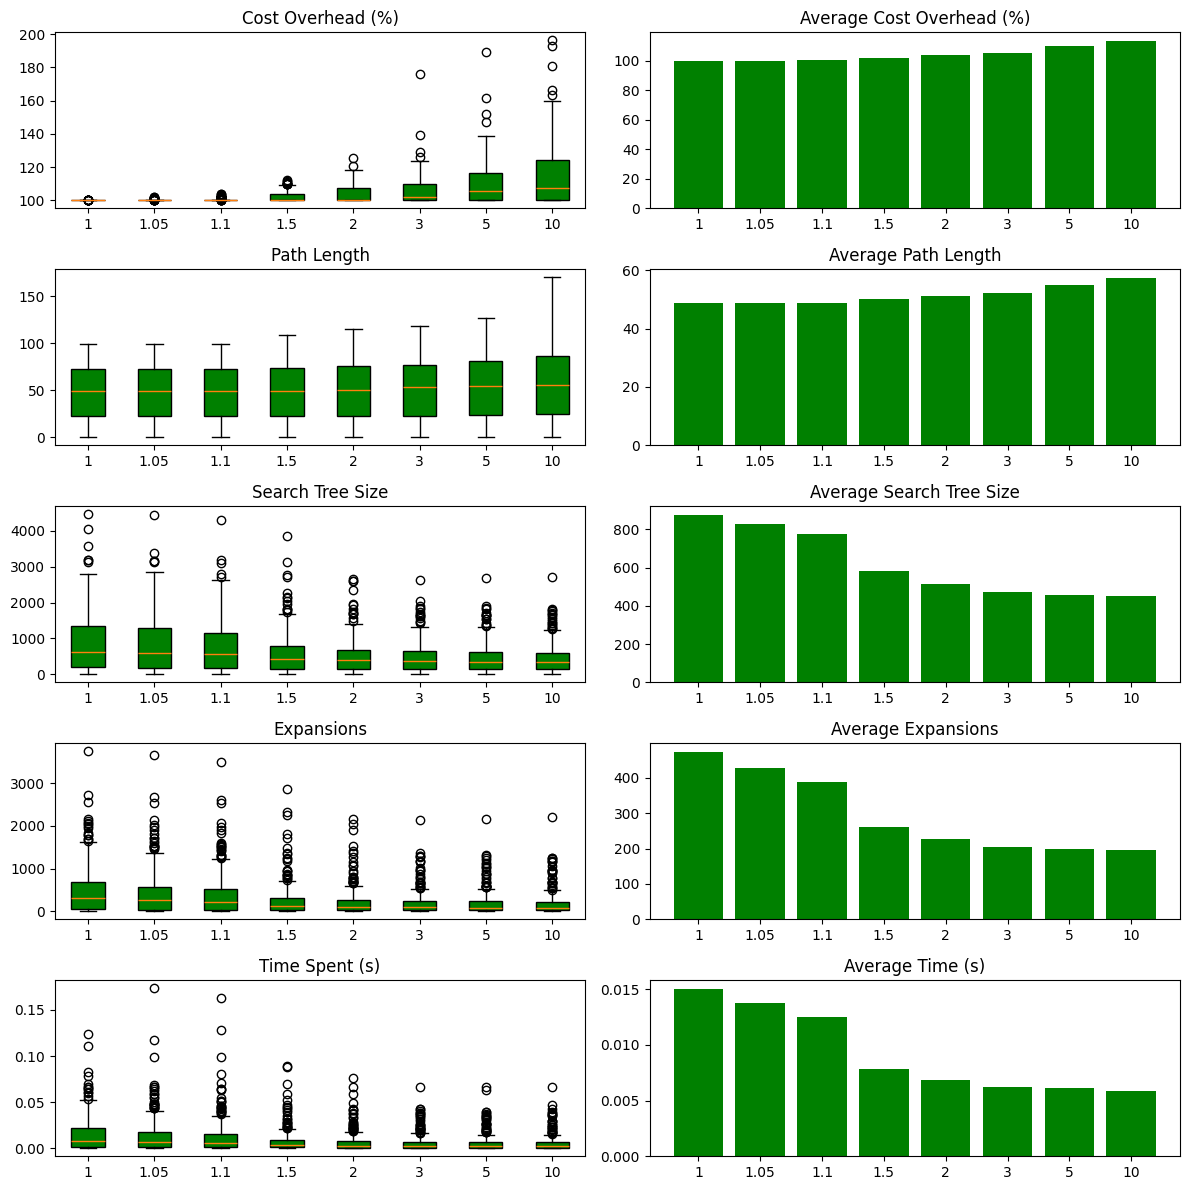

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 106%
Weight = 2: 110%
Weight = 3: 115%
Weight = 5: 124%
Weight = 10: 129%
=== Average path length: ===
Weight = 1: 300.395932
Weight = 1.05: 301.195070
Weight = 1.1: 302.910675
Weight = 1.5: 320.071943
Weight = 2: 331.482661
Weight = 3: 346.676000
Weight = 5: 374.786425
Weight = 10: 391.610130
=== Average search tree size: ===
Weight = 1: 21295
Weight = 1.05: 18130
Weight = 1.1: 15921
Weight = 1.5: 7649
Weight = 2: 5685
Weight = 3: 4810
Weight = 5: 4373
Weight = 10: 4107
=== Average expansions: ===
Weight = 1: 17859
Weight = 1.05: 14925
Weight = 1.1: 12528
Weight = 1.5: 5311
Weight = 2: 3723
Weight = 3: 3091
Weight = 5: 2738
Weight = 10: 2534
=== Average time usage: ===
Weight = 1: 0.7393 

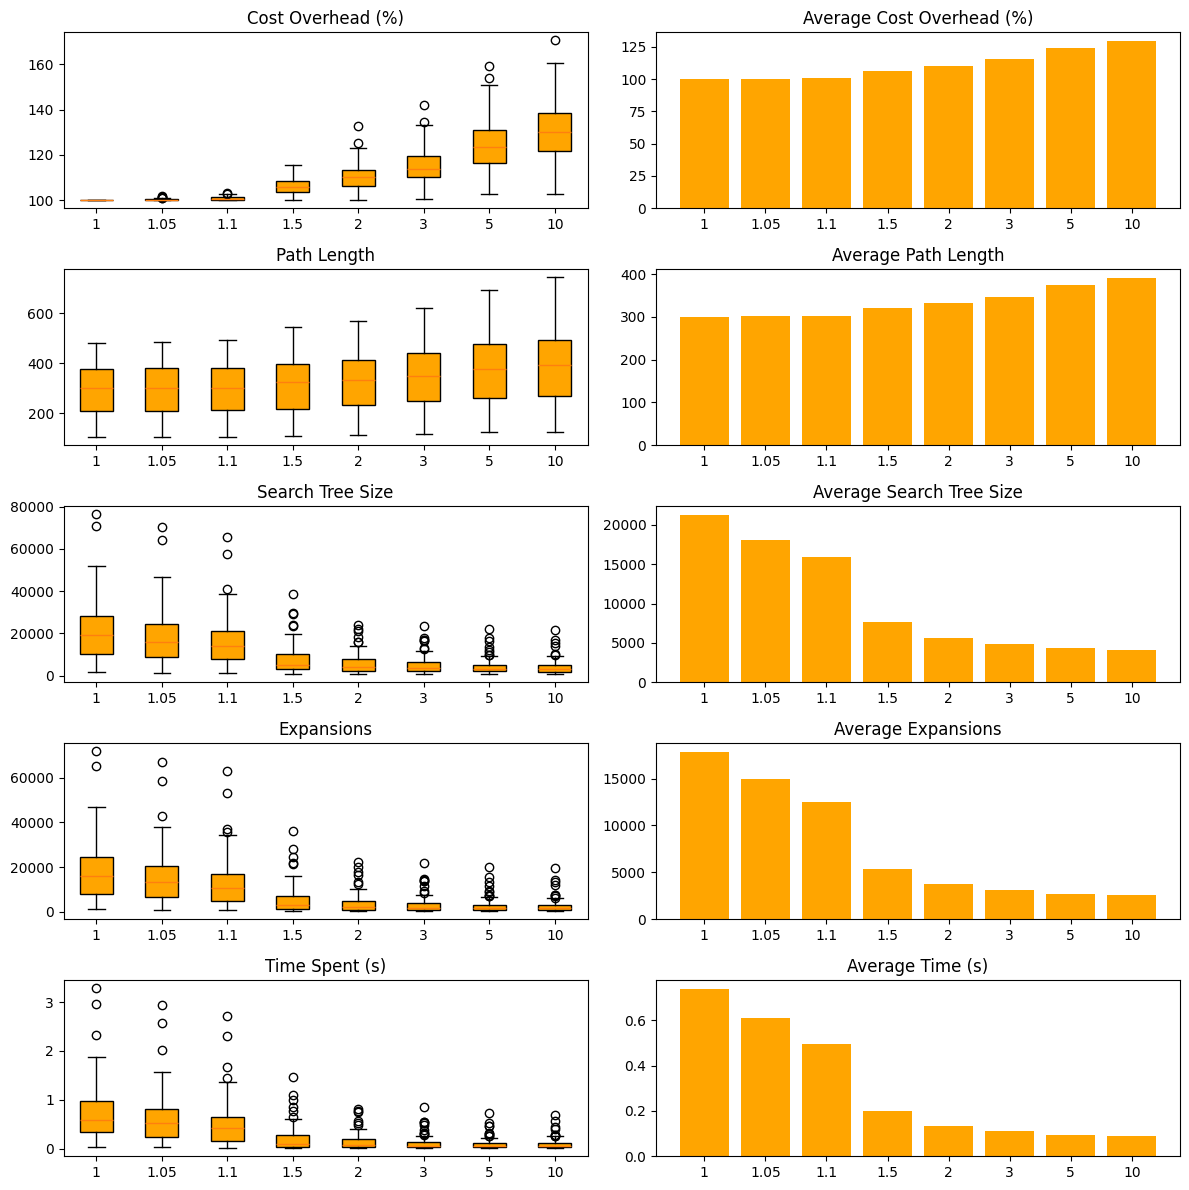

Running tests on Hard tasks (path length 500-1500), 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 107%
Weight = 2: 110%
Weight = 3: 115%
Weight = 5: 124%
Weight = 10: 130%
=== Average path length: ===
Weight = 1: 664.223326
Weight = 1.05: 665.395137
Weight = 1.1: 669.378862
Weight = 1.5: 711.414646
Weight = 2: 734.951173
Weight = 3: 768.277231
Weight = 5: 827.013143
Weight = 10: 864.387491
=== Average search tree size: ===
Weight = 1: 86737
Weight = 1.05: 74475
Weight = 1.1: 62132
Weight = 1.5: 18720
Weight = 2: 12578
Weight = 3: 10903
Weight = 5: 9925
Weight = 10: 9270
=== Average expansions: ===
Weight = 1: 79816
Weight = 1.05: 67397
Weight = 1.1: 54815
Weight = 1.5: 13772
Weight = 2: 8496
Weight = 3: 7293
Weight = 5: 6486
Weight = 10: 5951
=== Average time usage: ===
Weight = 1: 3.568

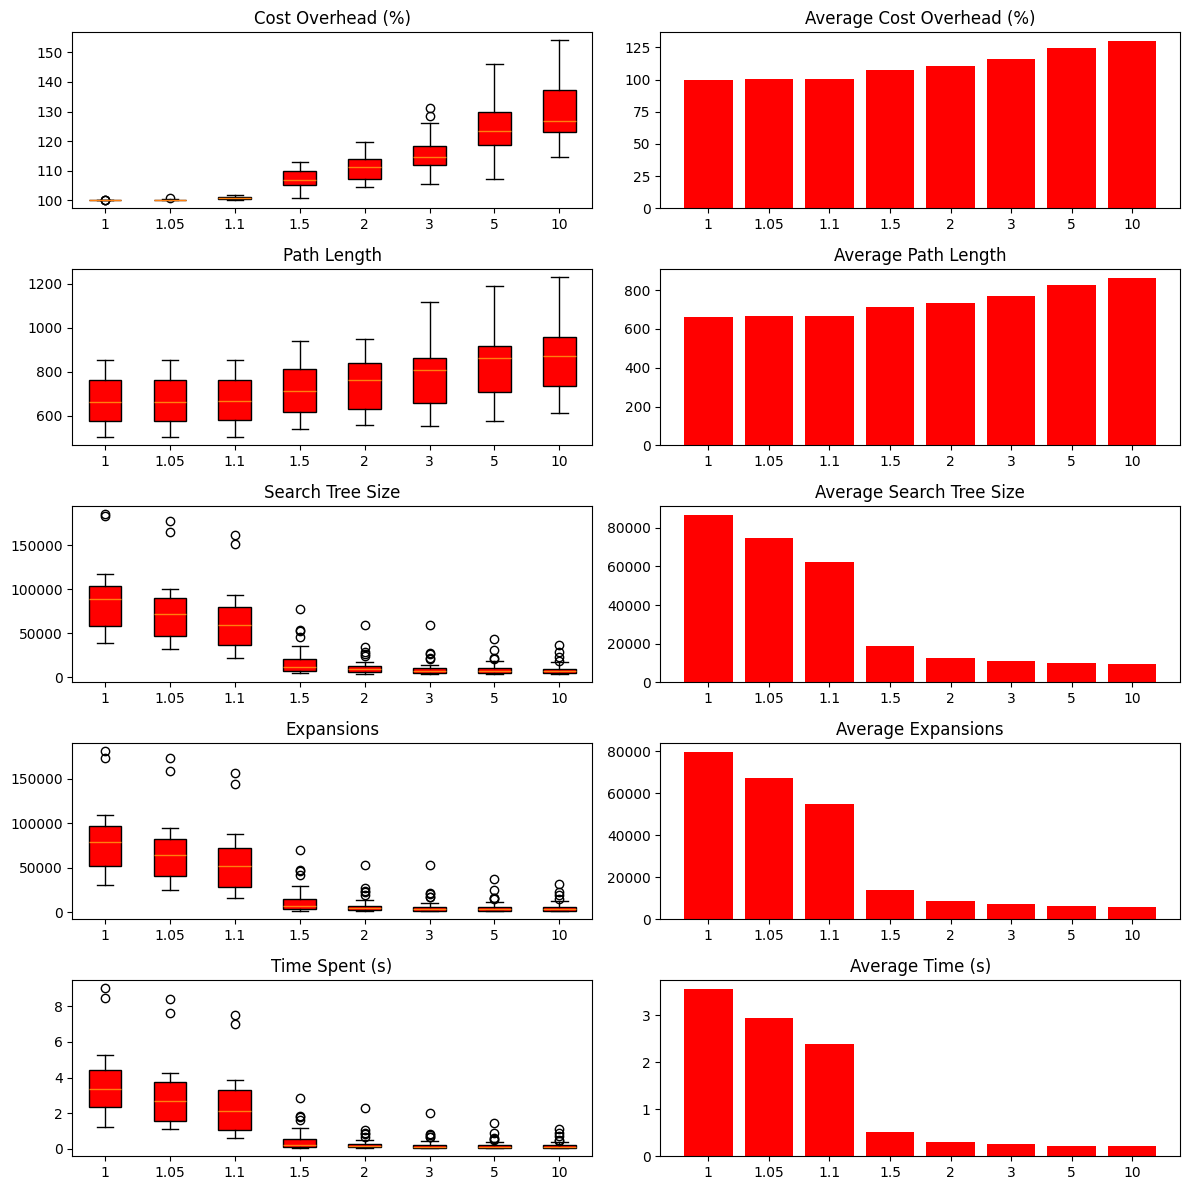

No Brutal tasks found in the scenarios


In [25]:
room_scenarios = [
    '8room_000.map.scen',
    '16room_008.map.scen',
    '32room_000.map.scen',
    '64room_003.map.scen',
]

test_on_scenarios(room_scenarios)

#### Test Summary

So, on room-shaped maps, the algorithms behave exactly like on the first three tests: the weighted algorithms give some cost overhead in change for a very serious time (and space) gain. Except that the cost overhead has increased even more and now it can reach 60% for algorithm with weight 10, which is STILL very low compared to the theoretical possible overhead of the algorithm. This is most likely because the algorithm finds not the best way through rooms where you have to go in the opposite direction to the goal. You may see such tendency in the MovingAI Weighted A* demo: https://movingai.com/SAS/SUB/

### 8.6. Computer Game Maps

This test includes maps from Dragon Age: Origins™ (2009) and Baldur's Gate II™ (2000). Maps of all sorts of layout are used.

Example of a map from Dragon Age: Origins:

<img src="./img/AR0011SR.png">

Running tests on Easy tasks (path length 0-100), 250 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 100%
Weight = 2: 101%
Weight = 3: 101%
Weight = 5: 102%
Weight = 10: 103%
=== Average path length: ===
Weight = 1: 50.237826
Weight = 1.05: 50.289874
Weight = 1.1: 50.371913
Weight = 1.5: 50.883264
Weight = 2: 51.175508
Weight = 3: 51.464145
Weight = 5: 52.029969
Weight = 10: 52.482488
=== Average search tree size: ===
Weight = 1: 576
Weight = 1.05: 503
Weight = 1.1: 474
Weight = 1.5: 387
Weight = 2: 355
Weight = 3: 340
Weight = 5: 337
Weight = 10: 334
=== Average expansions: ===
Weight = 1: 231
Weight = 1.05: 198
Weight = 1.1: 180
Weight = 1.5: 121
Weight = 2: 104
Weight = 3: 96
Weight = 5: 95
Weight = 10: 92
=== Average time usage: ===
Weight = 1: 0.0077 s
Weight = 1.05: 0.0061 s
Weight = 1.

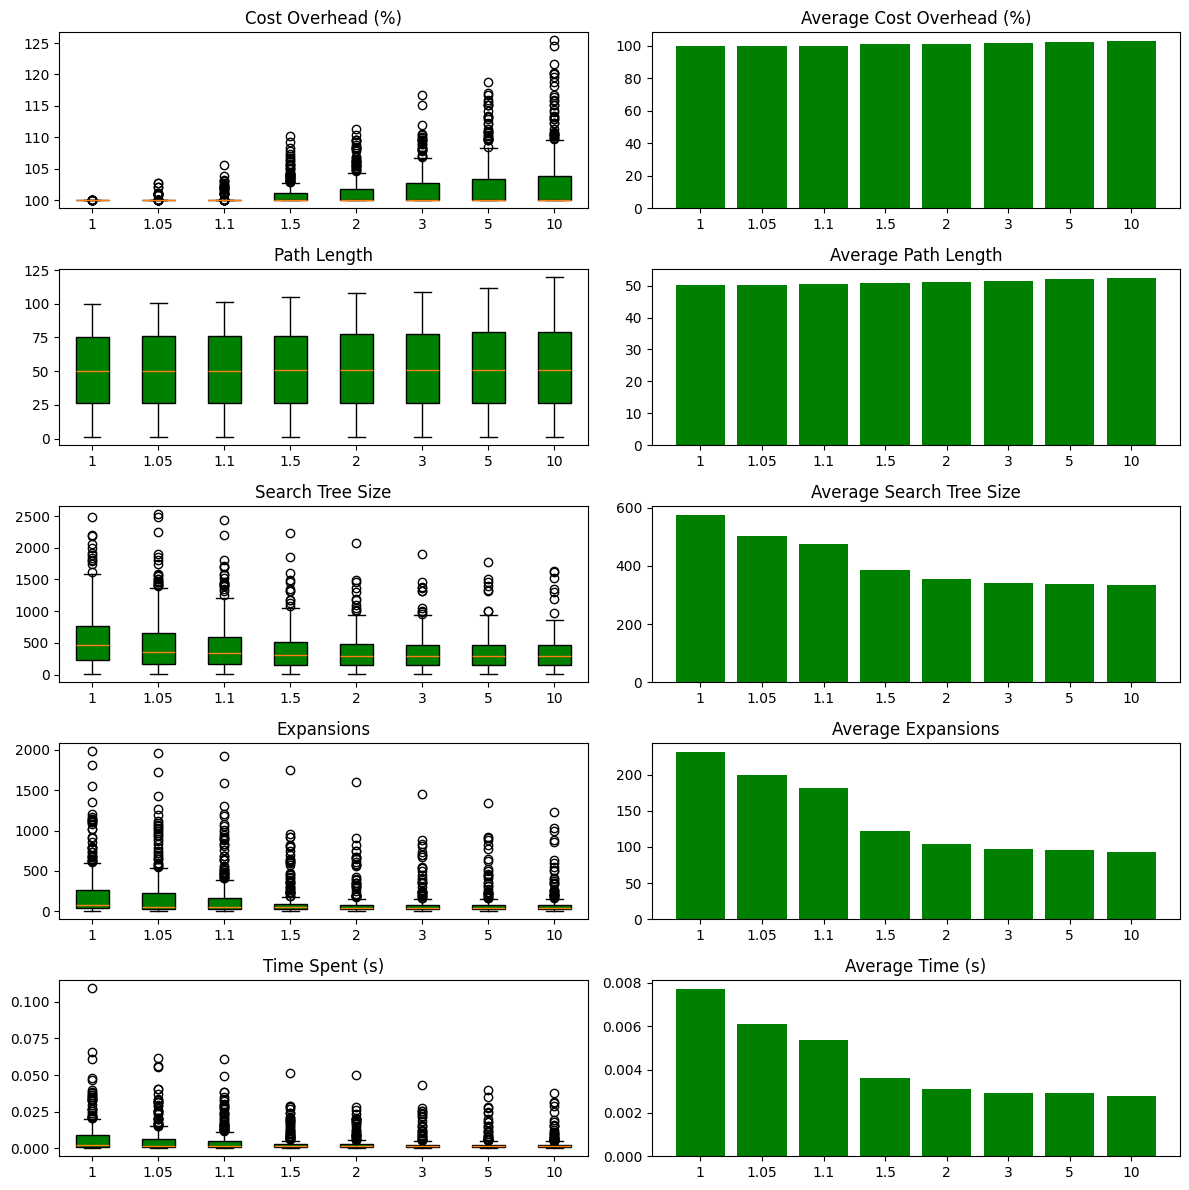

Running tests on Medium tasks (path length 100-500), 100 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 102%
Weight = 2: 104%
Weight = 3: 106%
Weight = 5: 108%
Weight = 10: 111%
=== Average path length: ===
Weight = 1: 278.983249
Weight = 1.05: 279.963809
Weight = 1.1: 281.206033
Weight = 1.5: 286.966789
Weight = 2: 291.496507
Weight = 3: 297.735056
Weight = 5: 303.689728
Weight = 10: 311.519921
=== Average search tree size: ===
Weight = 1: 9775
Weight = 1.05: 7920
Weight = 1.1: 7648
Weight = 1.5: 6165
Weight = 2: 5264
Weight = 3: 4526
Weight = 5: 4120
Weight = 10: 4017
=== Average expansions: ===
Weight = 1: 7509
Weight = 1.05: 6778
Weight = 1.1: 6485
Weight = 1.5: 4996
Weight = 2: 4094
Weight = 3: 3421
Weight = 5: 2998
Weight = 10: 2911
=== Average time usage: ===
Weight = 1: 0.2604 s
Weig

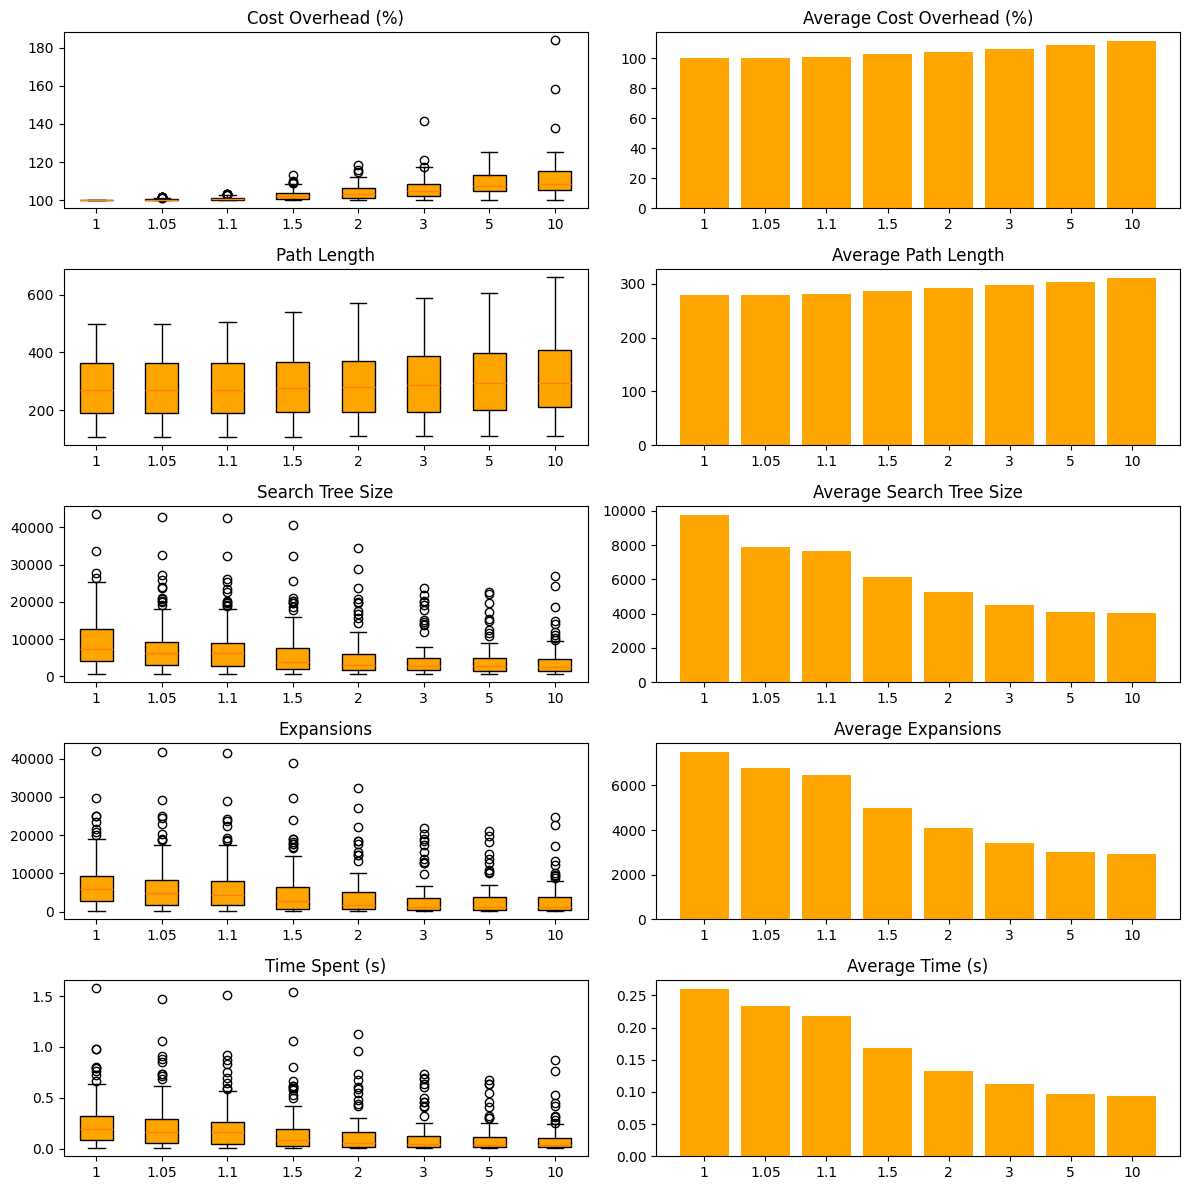

Running tests on Hard tasks (path length 500-1500), 30 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 100%
Weight = 1.5: 103%
Weight = 2: 104%
Weight = 3: 107%
Weight = 5: 110%
Weight = 10: 112%
=== Average path length: ===
Weight = 1: 955.480447
Weight = 1.05: 959.918251
Weight = 1.1: 965.918629
Weight = 1.5: 989.570966
Weight = 2: 1000.410536
Weight = 3: 1024.401101
Weight = 5: 1057.495759
Weight = 10: 1074.798128
=== Average search tree size: ===
Weight = 1: 26036
Weight = 1.05: 24822
Weight = 1.1: 24444
Weight = 1.5: 21128
Weight = 2: 18453
Weight = 3: 15703
Weight = 5: 14468
Weight = 10: 13351
=== Average expansions: ===
Weight = 1: 24238
Weight = 1.05: 23611
Weight = 1.1: 23166
Weight = 1.5: 19375
Weight = 2: 16125
Weight = 3: 13063
Weight = 5: 11754
Weight = 10: 10566
=== Average time usage: ===
Weight 

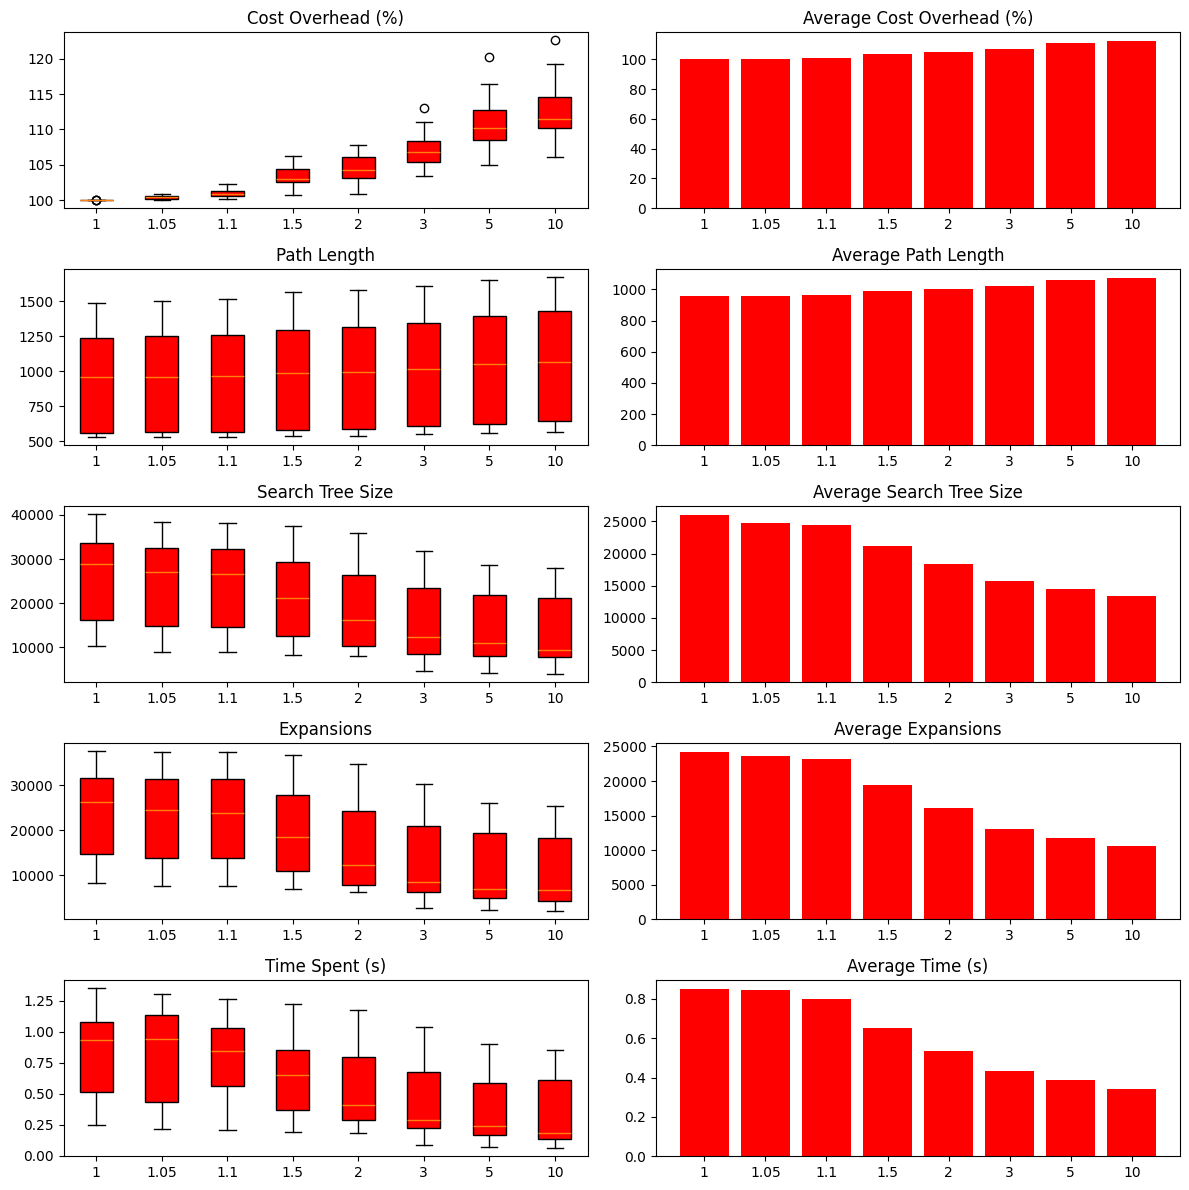

Running tests on Brutal tasks (path length >1500), 10 tasks total...
 __________________________________________________ 
[||||||||||||||||||||||||||||||||||||||||||||||||||]
===== SUMMARY =====
=== Average optimality ratio: ===
Weight = 1: 100%
Weight = 1.05: 100%
Weight = 1.1: 101%
Weight = 1.5: 104%
Weight = 2: 105%
Weight = 3: 108%
Weight = 5: 112%
Weight = 10: 114%
=== Average path length: ===
Weight = 1: 1561.272308
Weight = 1.05: 1571.296276
Weight = 1.1: 1587.367763
Weight = 1.5: 1632.876125
Weight = 2: 1653.703960
Weight = 3: 1693.806312
Weight = 5: 1754.222668
Weight = 10: 1784.804292
=== Average search tree size: ===
Weight = 1: 32247
Weight = 1.05: 31648
Weight = 1.1: 31337
Weight = 1.5: 25644
Weight = 2: 18396
Weight = 3: 13864
Weight = 5: 11901
Weight = 10: 10688
=== Average expansions: ===
Weight = 1: 30856
Weight = 1.05: 30396
Weight = 1.1: 30000
Weight = 1.5: 22798
Weight = 2: 13379
Weight = 3: 7901
Weight = 5: 5985
Weight = 10: 4780
=== Average time usage: ===
Weight 

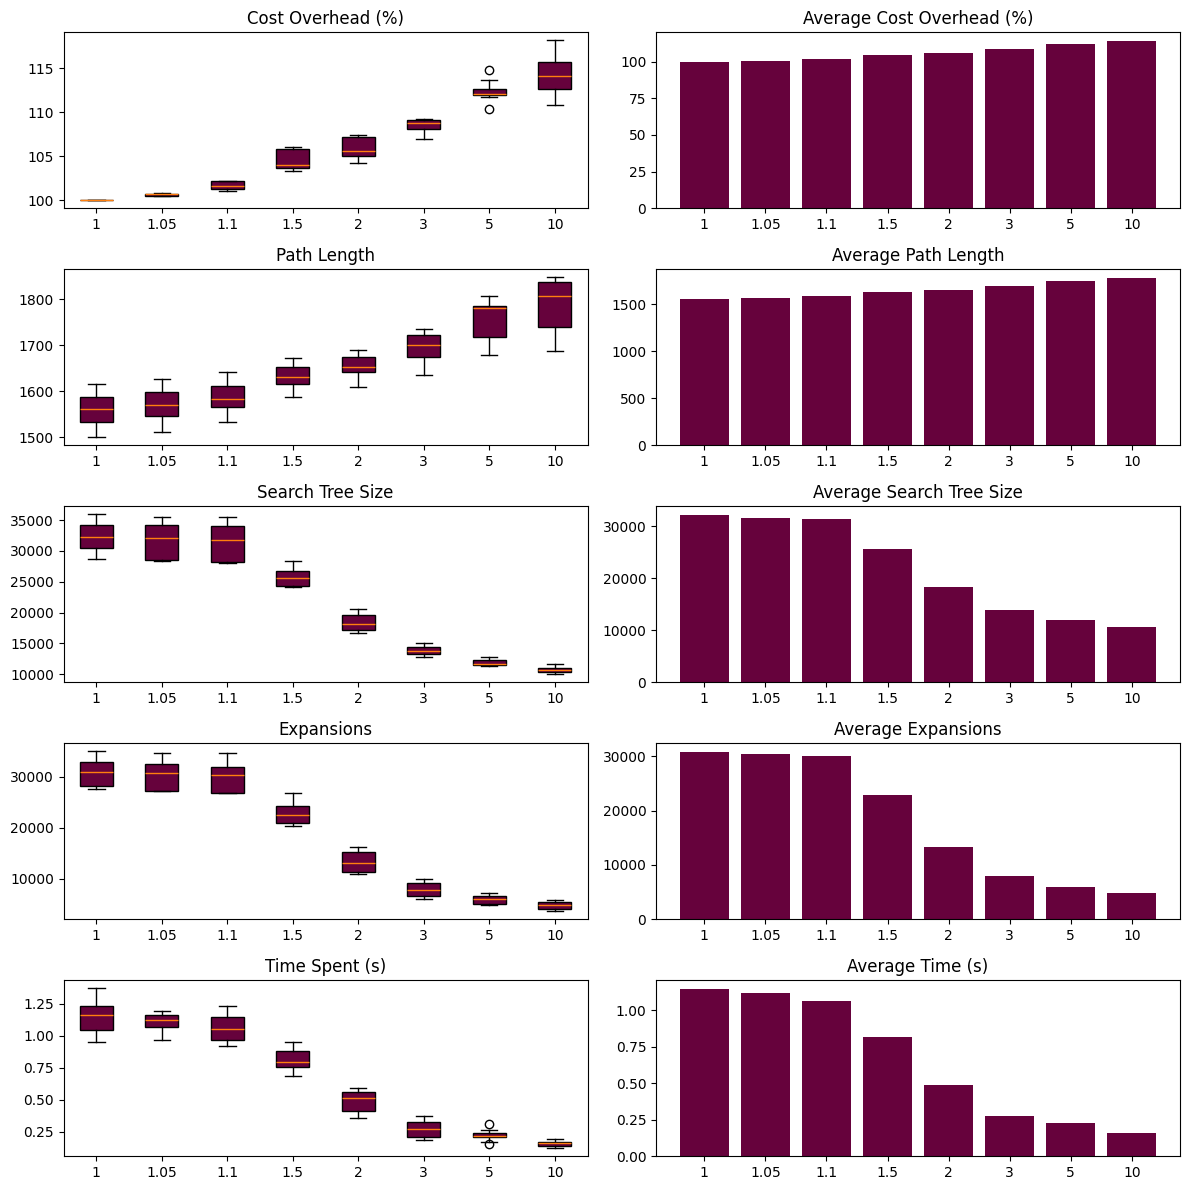

In [26]:
game_scenarios = [
    'AR0011SR.map.scen',
    'AR0022SR.map.scen',
    'AR0044SR.map.scen',
    'AR0202SR.map.scen',
    'AR0205SR.map.scen',
    'AR0405SR.map.scen',
    'AR0600SR.map.scen',
    'AR0602SR.map.scen',
    'AR0700SR.map.scen',
    'arena2.map.scen',
    'brc202d.map.scen',
    'brc204d.map.scen',
    'brc501d.map.scen',
    'brc504d.map.scen',
    'combat.map.scen',
    'den504d.map.scen',
    'den900d.map.scen',
    'isound1.map.scen',
    'lak304d.map.scen',
    'lak405d.map.scen',
    'orz103d.map.scen',
    'ost004d.map.scen'
]

test_on_scenarios(game_scenarios)

#### Test Summary

These graphs represent something in between the city maps and the maze maps. This could be due to the varying structure of the game maps. They too can be thought of something between the city maps and the maze maps. In some of them, you must make a big detour around a long obstacle of complex shape (in contrast to rectangular city houses) between two seemingly nearby cells, while still expanding many empty space cells, thus spending some time for it. Just take a look at this one, where heuristic is certainly not as useful as on city maps:

<img src="./img/orz103d.png">

## Overall Summary

So, as we can see, the weighted algorithms, in theory, can produce very sub-optimal solutions, several times longer than the optimal ones, but in practice, while finding only a little sub-optimal paths, they save a lot of execution time. If you ran the notebook from the very beginning once, you will see that, with the random seed used, no algorithm on no test ever found more than 2x longer path. So, if your task requires finding tons of paths that don't require being strictly optimal, then WA* is your choice. Perhaps a good trade-off between path length and finding time is a cost of 1.5 or 2, but it depends on the task. Just remember that in THEORY, the algorithm can still generate very bad solutions, if that is critical for you.